<h3>A practical guide for using the Python package <a href="https://github.com/ing-bank/popmon">popmon</a></h3>

<h3>Introduction</h3>

Our clients often ask us what the shelf life of a predictive model is. Unfortunately, this is not something where you can apply a general rule of thumb. The shelf time of a model completely depends on the changes in the world around the model, a.k.a. the model drift, which can be split into concept drift and data drift as my colleague Jurriaan Nagelkerke explains into detail in this <a href="https://www.theanalyticslab.nl/model-drift-automatic-retraining-and-how-not-to-ruin-your-models/">very interesting article</a>. In this article you can not only learn about model drift, concept drift and data drift, but also why (automatic) retraining isn't always the best solution, and even better yet, what you should do to keep your models alive and kicking! I highly recommend you to read this article. In this article I assume you already know about model drift and are looking for a practical example how to implement monitoring of models in production.

To be able to monitor the model drift, ING has created their own Python package: popmon. We love (their work on) this package, but it did take us a little while to comprehend how to use this package in a way that would help us get a sense of our model drift. That’s why we decided to help all of you newbies to popmon, who are also interested in monitoring model drift. The beauty of this package lies in the fact that ING definitely applied the KISS (keep it simple stupid) method when developing it. Meaning we only need a couple of smart functions to reach our goals. Unfortunately for us, Data Scientists, we always want to exactly grasp what we are doing, so this also meant a deep dive into this package and into what these functions were doing. So, let us take you on a (short and simple) ride through popmon.

<h3>Our use case</h3>

Since there are multiple use cases for popmon, we want to start with describing the use case we will be focusing on in this article: a Data Scientist/Analyst created a predictive model, which will be taken into production and therefore model drift monitoring needs to be setup for this model. 

To be more precise: We want to keep track of the data that is used to score our model and constantly check whether this data is not too different from the data where the model was trained on. This is a very common use case, although often this monitoring is not set up.

<h3>Installation of the package</h3>
And then, before we can really start, we need to start by installing popmon, which is as simple as: 

!pip install popmon

<br><h3>Initialize the notebook</h3>

In [1]:
# import packages
import pandas as pd
import pickle
import popmon
from popmon import resources

In [2]:
# make sure all output in each cell shows, without explicitly printing them
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# adjust default display settings of pandas dataframes
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<br><h3>The data</h3>
This is a dataset containing multiple features, for the sake of simplicity, we only keep a couple of these features and pretend we used these features to predict a column with the name isActive. Since this is the dependent variable, which we can't monitor in production since it is unknown, we've removed this variable from our trainingset as well.

<h5>Import our example data</h5>

In [4]:
df = pd.read_csv(resources.data("test.csv.gz"), parse_dates=["date"])
df = df[["age", "balance", "eyeColor", "favoriteFruit", "gender", "latitude", "transaction", "currency", "date"]]
df["date"] = df["date"].dt.to_period("M")

In [5]:
df.head()

age    balance eyeColor favoriteFruit  gender   latitude  transaction  \
0   16  $1,333.24     grey        banana  female  18.821230      1131.03   
1   57  $3,777.44    brown        banana  female -82.134610      -896.55   
2   26  $1,248.97     blue    strawberry  female  62.383017      1224.04   
3   63  $1,049.77    green    strawberry    male -26.913326       541.08   
4   74  $2,942.64      red    strawberry    male  -2.777228      -372.62   

  currency     date  
0      DOL  2015-05  
1      DOL  2015-06  
2      DOL  2015-10  
3      DOL  2015-06  
4      DOL  2015-03

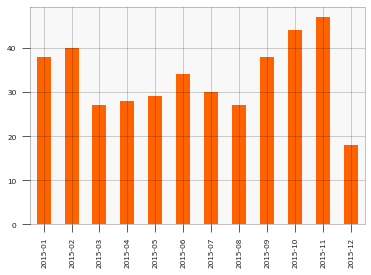

In [6]:
_ = df['date'].value_counts().sort_index().plot(kind='bar')

<br><br>
<h5>Create the different batches we would have when this model would have been in production</h5> 
Because we're using a single example dataset for now, we need to split this into a couple of different batches to recreate our example of taking a model into production and scoring new data regularly:

- our traindata
- the first batch of scoring data when the model is in production
- the second batch of scoring data when the model is in production
- the third batch of scoring data when the model is in production

Let's say we want to check our model scoring data for changes on a monthly basis.

In [7]:
# our traindata is created on data of the first 8 months of 2015
df_train = df[df.date < "2015-09"]

In [8]:
# batch_1 would be the first batch to be fed to the model after this has been put into production
batch_1 = df[df.date == "2015-09"]

In [9]:
# batch_2 would be the second batch to be fed to the model after this has been put into production
# we won't use this dataset in this example, but you can use it when playing around with this notebook yourself
batch_2 = df[df.date == "2015-10"]

In [10]:
# batch_3 would be the third batch to be fed to the model after this has been put into production
# we won't use this dataset in this example, but you can use it when playing around with this notebook yourself
batch_3 = df[df.date == "2015-11"]

<br>
<h3>Initalizing the monitoring</h3>

We will use the trainingdata to learn popmon what our data looks like, already dividing the data into the different months, so popmon knows what it should expect from a new month. This function uses another package built by ING: <a href="https://github.com/histogrammar/histogrammar-python">histogrammar</a>. A key strength of popmon (using histogrammar) is to save all that is needed to monitor for each feature in a histogram object. Histograms are small in terms of storage and safe in terms of privacy risks as no specific values need to be stored. Also, histograms can easily be compared to other histogram objects, resulting in fast processing once the histograms are created. These histograms are used to calculate all the metrics used to create the alerts. Popmon generates a whole load of metrics, we've given a short overview and explanation of all of these metrics in this <a href="https://www.theanalyticslab.nl/the-statistics-underlying-the-popmon-hood/">article</a>.

In [11]:
hists = df_train.pm_make_histograms(time_axis="date")
hists

2022-03-25 16:49:36,833 INFO [histogram_filler_base]: Filling 8 specified histograms. auto-binning.
100%|█████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.50it/s]


{'date:age': <Categorize values=SparselyBin size=8,
 'date:balance': <Categorize values=Categorize size=8,
 'date:currency': <Categorize values=Categorize size=8,
 'date:eyeColor': <Categorize values=Categorize size=8,
 'date:favoriteFruit': <Categorize values=Categorize size=8,
 'date:gender': <Categorize values=Categorize size=8,
 'date:latitude': <Categorize values=SparselyBin size=8,
 'date:transaction': <Categorize values=SparselyBin size=8}

<br><br><br>
We can get the binning specifications from the histogrammar objects, this way we can make sure that the histograms created on a new batch will be exactly the same.

In [12]:
bin_specs = popmon.get_bin_specs(hists)
bin_specs

{'date:age': [{}, {'binWidth': 2.0, 'origin': 9.5}],
 'date:balance': [{}, {}],
 'date:currency': [{}, {}],
 'date:eyeColor': [{}, {}],
 'date:favoriteFruit': [{}, {}],
 'date:gender': [{}, {}],
 'date:latitude': [{},
  {'binWidth': 4.347556988888889, 'origin': -85.24212737777779}],
 'date:transaction': [{},
  {'binWidth': 62.90755555555556, 'origin': -1019.9291111111112}]}

<br><br><br>

Now we're ready to compare new periods to the reference (train) period. Popmon will provide a lot of useful output and will guide us in evaluating whether new data is similar (enough) to reference data.

Before we look at more popmon output, it's good to briefly introduce some key concepts of popmon. For more detail, we refer to the package documentation, but these concepts are essential to understand:

- **profiles**: per batch (time period), popmon calculates several profile statistics for each feature, like the mean, min, max, missings, distinct value count. 
- **comparisons**: each new batch is compared to the specified reference (see next concept) and several comparison statistics are calculated, mainly significance tests (chi square, kolmogorov-smirnov) to evaluate the difference in the histogram distribution of the new batch compared to the reference.     
- **references**: what to compare with? popmon offers four options: *ref*erence data - a specified external source - *roll*ing window over preceding time periods, *prev1* -  the preceding time period and *expanding* hence all preceding time periods.
- **alerts**: a traffic light style alerting based on the profiles and comparisons, to only warn when something important (enough) is different in the data, compared to the reference. With different, customizable thresholds green, yellow and red traffic lights are defined for each feature and each metric.    

We won't go into detail for now, but it might be useful to know that it is possible to change the monitoring rules popmon uses to create the alerts. We can change the rules for a single metric (which is applied to all features) or for a (group of) feature(s). Below you can find a code example on how to change the monitoring rules, where we for instance set the boundaries for age to 18 and 100 for a "yellow" alert and to 0 and 120 for a "red" alert. Meaning that if a value in the feature age is outside of these boundaries an alert will be triggered.

In [13]:
monitoring_rules = {"*_pull": [9, 3, -3, -9]
                    , "*_zscore": [7, 4, -4, -7]
                    , "[!p]*_unknown_labels": [0.5, 0.5, 0, 0]
                    , "age:min": [120, 100, 18, 0], "age:max": [120, 100, 18, 0]
                   }

Oh and one more thing, because there is one term you will often see in the output but might not immediately be clear to you: the **pull**. Pull refers to *'the normalized residual of a value of interest with respect to the selected reference'*. Not sure if that made things clearer yet... In our own words, the pull is the standardized version of each statistic so that they are on the same scale and we can have the same threshold for different statistics. The pull indicates to what extent a value on a statistic should be interpreted as an actual difference in the new data as compared to the reference data. It's calculated for every profile of every feature like this:

$pull = (value - reference[mean]) / reference[standard deviation]$

<br>
<h3>Ready to calculate the monitoring metrics and alerts</h3>

>JN: Ik heb nog één overweging (verder is het helemaal top!! paar kleine aanpassingen in tekst gedaan hier en daar, zoals korte toelichting op term pull): je laat hierna een aantal zaken zien door het zowel op de traindata toe te passen (dan gaat popmon daarbinnen op zoek naar afwijkende perioden) en op de scoredata. Gezien hoe je mooi het verhaal hebt ingeleid als 'we hebben traindata en willen zien of scoredata daar voldoende op lijkt' denk ik dat het verwarrend kan zijn om ook nog naar traindata te kijken. Zou dus voorstellen: heb het allleen over de profiles en comparisons obv de scoredata, niet obv de traindata.  

> In een apart notebook - comments JN_JJ_JN2.ipynb - heb ik dat direct doorgevoerd om te kijken of dat nog ergens tot conflicten met de verhaallijn geldt. Als je dat liever zelf doet, dan is dit mijn laatste comment :)  

To illustrate the type of objects popmon creates, we start with calculating all the metrics (and alerts) on the traindata. Do note that this is not necessary when we want to see if new scoring data is similar (enough) to training data to be used for scoring. 

The train data contains multiple periods/batches of data (the time-axis parameter we used to make the histograms). The datastore object we're creating here is essentially a dictionary holding all calculated metrics and more importantly the alerts that were generated due to these metrics. It is recommended to explore this dictionary to see what you can expect and, even better, to decide how you want to use this information to create your own alerts. Where you can use these values to trigger the messages (for instance Slack, Email) you want to receive. Making this completely and easily adjustable to the preferred way of working in your company.

In [15]:
# calculate the metrics based on all histograms and the monitoring rules we adjusted (when no adjustments made you can ignore this parameter, popmon will use its own default)
datastore = popmon.stability_metrics(hists=hists, monitoring_rules=monitoring_rules)

2022-03-25 16:45:04,415 INFO [hist_splitter]: Splitting histograms "hists" as "split_hists"
2022-03-25 16:45:04,439 INFO [hist_comparer]: Comparing "split_hists" with rolling sum of 1 previous histogram(s).
2022-03-25 16:45:12,094 INFO [hist_comparer]: Comparing "split_hists" with reference "split_hists"
2022-03-25 16:45:13,702 INFO [pull_calculator]: Comparing "comparisons" with median/mad of reference "comparisons"
2022-03-25 16:45:14,040 INFO [hist_profiler]: Profiling histograms "split_hists" as "profiles"
2022-03-25 16:45:14,297 INFO [pull_calculator]: Comparing "profiles" with median/mad of reference "profiles"
2022-03-25 16:45:16,044 INFO [apply_func]: Computing significance of (rolling) trend in means of features
2022-03-25 16:45:16,262 INFO [compute_tl_bounds]: Calculating static bounds for "profiles"
2022-03-25 16:45:17,184 INFO [compute_tl_bounds]: Calculating static bounds for "comparisons"
2022-03-25 16:45:17,288 INFO [compute_tl_bounds]: Calculating traffic light alerts f

Since we've asked popmon to calculate stability_metrics on the set of training period histograms without specifying a reference, it will check whether all periods *within* the training period have similar values and distributions, as compared to *all other periods within the training period*.

In [17]:
# let's look at what content can be found in the datastore
datastore.keys()

dict_keys(['hists', 'split_hists', 'comparisons', 'profiles', 'ba5205ef-e24a-4de1-b365-084cac798149', 'dynamic_bounds', '92465948-f448-48c7-a068-622e114ab15c', 'dynamic_bounds_comparisons', 'static_bounds', '15e571eb-d205-4aaa-9f89-6abd7ffea888', 'traffic_lights', 'static_bounds_comparisons', 'fcb4ca28-103c-4fe1-ac54-d0dd72319919', 'alerts'])

In [18]:
# you can access the datastore like you would any other dictionary
# we will just show you one random example here
datastore['comparisons']['age']

prev1_ks  prev1_ks_zscore  prev1_ks_pvalue  prev1_pearson  \
date                                                                 
2015-01       NaN              NaN              NaN            NaN   
2015-02  0.946779         0.435895         0.331457  -5.551115e-17   
2015-03  0.665432        -0.731410         0.767735  -7.380564e-02   
2015-04  0.583586        -1.201607         0.885242   2.000875e-02   
2015-05  0.557784        -1.370834         0.914787   3.796117e-01   
2015-06  1.332077         1.575995         0.057514  -4.175666e-02   
2015-07  0.720158        -0.460633         0.677469   9.555846e-02   
2015-08  0.656204        -0.780122         0.782340  -2.902757e-01   

         prev1_chi2  prev1_chi2_norm  prev1_chi2_zscore  prev1_chi2_pvalue  \
date                                                                         
2015-01         NaN              NaN                NaN                NaN   
2015-02   33.504079         1.015275           0.143809           0.442826   
2015-03   31.669907         0.959694          -0.083522           0.533282   
2015-04   26.657297         0.952046          -0.092784           0.536962   
2015-05   17.787931         0.684151          -1.191912           0.883352   
2015-06   27.576876         0.919229          -0.234877           0.592848   
2015-07   26.051765         0.814118          -0.710531           0.761312   
2015-08   29.590741         0.896689          -0.352139           0.637633   

         prev1_chi2_max_residual  prev1_chi2_spike_count  prev1_max_prob_diff  \
date                                                                            
2015-01                      NaN                     NaN                  NaN   
2015-02                 2.001351                     0.0             0.100000   
2015-03                 2.510413                     0.0             0.148148   
2015-04                 2.115063                     0.0             0.148148   
2015-05                 1.414657                     0.0             0.102217   
2015-06                 2.237766                     0.0             0.137931   
2015-07                 1.940285                     0.0             0.117647   
2015-08                 1.517574                     0.0             0.074074   

         prev1_unknown_labels    ref_ks  ref_ks_zscore  ref_ks_pvalue  \
date                                                                    
2015-01                   NaN  0.442418      -2.312559       0.989627   
2015-02                   NaN  0.918138       0.336679       0.368180   
2015-03                   NaN  0.462763      -2.118823       0.982947   
2015-04                   NaN  0.907939       0.300592       0.381863   
2015-05                   NaN  0.652802      -0.798327       0.787660   
2015-06                   NaN  1.183783       1.168678       0.121267   
2015-07                   NaN  0.586110      -1.185666       0.882123   
2015-08                   NaN  0.321042      -3.893301       0.999951   

         ref_pearson   ref_chi2  ref_chi2_norm  ref_chi2_zscore  \
date                                                              
2015-01     0.446020  29.987816       0.749695        -1.153065   
2015-02     0.258062  30.261057       0.756526        -1.116126   
2015-03     0.469252  27.002309       0.675058        -1.572555   
2015-04     0.346271  29.532473       0.738312        -1.215136   
2015-05     0.487455  22.740538       0.568513        -2.230893   
2015-06     0.580993  22.905891       0.572647        -2.203816   
2015-07     0.114513  28.046507       0.701163        -1.422374   
2015-08     0.464718  20.608440       0.515211        -2.593056   

         ref_chi2_pvalue  ref_chi2_max_residual  ref_chi2_spike_count  \
date                                                                    
2015-01         0.875558               2.368508                   0.0   
2015-02         0.867816               2.732871                   0.0   
2015-03         0.9420

<br>Depending on the way your company prefers to work, you can store these objects as (pickle) files, or write them to a database. This way you can retrieve and expand them every time you use the model on a new batch of data.

In [19]:
# save the objects as pickles (we could also create jsons and/or store in a database)
pickle.dump(hists, open(f"all_hist.pkl", "wb"))
pickle.dump(monitoring_rules, open(f"monitoring_rules.pkl", "wb"))
pickle.dump(datastore, open(f"datastore.pkl", "wb"))

<br>
<h3>Now let's try to use the monitoring on our first new batch of data</h3>

Earlier, we prepared the scoring batches. Using those batches of data we are ready to check for drift,  compared to the histograms we made based on the training data. So let's start doing that now.

<h5>Create the histograms of the new batch, using the same bin specifications</h5>

In [15]:
# start by generating the histograms on the new dataset, using the same bin specifications to make the histograms comparable
new_hists = batch_1.pm_make_histograms(time_axis="date", bin_specs=bin_specs)
new_hists

2022-03-25 16:53:19,529 INFO [histogram_filler_base]: Filling 8 specified histograms. auto-binning.
100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 82.86it/s]


{'date:age': <Categorize values=SparselyBin size=1,
 'date:balance': <Categorize values=Categorize size=1,
 'date:currency': <Categorize values=Categorize size=1,
 'date:eyeColor': <Categorize values=Categorize size=1,
 'date:favoriteFruit': <Categorize values=Categorize size=1,
 'date:gender': <Categorize values=Categorize size=1,
 'date:latitude': <Categorize values=SparselyBin size=1,
 'date:transaction': <Categorize values=SparselyBin size=1}

<br>
Now that we have histogram objects for the new scoring batch and we already had created those for the training data, we can calculate the metrics of the new batch, using our traindata as the reference data.

In [16]:
batch_datastore = popmon.stability_metrics(hists=new_hists, monitoring_rules=monitoring_rules, reference_type='external', reference=hists)

2022-03-25 16:55:20,545 INFO [hist_splitter]: Splitting histograms "hists" as "split_hists"
2022-03-25 16:55:20,567 INFO [hist_comparer]: Comparing "split_hists" with rolling sum of 1 previous histogram(s).
2022-03-25 16:55:25,588 INFO [hist_splitter]: Splitting histograms "ref_hists" as "split_ref_hists"
2022-03-25 16:55:25,599 INFO [hist_comparer]: Comparing "split_hists" with reference "split_ref_hists"
2022-03-25 16:55:25,765 INFO [pull_calculator]: Comparing "comparisons" with median/mad of reference "comparisons"
2022-03-25 16:55:25,876 INFO [hist_profiler]: Profiling histograms "split_hists" as "profiles"
2022-03-25 16:55:25,906 INFO [hist_profiler]: Profiling histograms "split_ref_hists" as "ref_profiles"
2022-03-25 16:55:25,997 INFO [pull_calculator]: Comparing "profiles" with reference "ref_profiles"
2022-03-25 16:55:26,227 INFO [apply_func]: Computing significance of (rolling) trend in means of features
2022-03-25 16:55:26,253 INFO [compute_tl_bounds]: Calculating static bou

To get a deeper understanding of what we end up with now, let's have a deeper look at four objects in the batch_datascore we just created: 
- ***profiles*** We introduced these earlier on: This contains a lot of statistics on the distribution of the features in the new batch: The number of values, mean, min, max, etc. And since the batch has multiple observations, it also contains information on the deviation of each of these statistics: the standard deviation of the mean, of the number of values, of the min,... And finally, it contains a comparison of these statistics with those in the reference data, resulting in all _pull metrics in the profiles. These are used to specify what profile statistics seem really different from the reference data and get a yellow or red traffic light.
- ***comparisons*** We also introduced this earlier: This contains actual comparisons between the distributions in the new batch compared to the reference data: It holds many test statistics like pearson, chi square and Kolmogorov-Smirnov and the statistical significance of the values. For alerting, also in the comparisons  _pull metrics are added to specify which comparisons are big enough to get a yellow or red traffic light.
- ***alerts*** This object summarizes and guides us if there are significant issues with the new data. The monitoring_rules we specified earlier are used to evaluate whether thresholds for pull, z-scores or custom threshold values like minimum or maximum age are met.  
- ***traffic lights*** These indicate which of the pull or zscore or customer thresholds for feature statistics triggered the traffic light. In this overview of all considered values for alerting, a 0 indicates no alert ('green' traffic light), a 1 indicates a yellow traffic light and a 2 is most severe: a red traffic light.

Let's explore the profiles, comparisons and alerts now for one feature, age:
 

In [17]:
# let's checkout the same element in the datastore as we saw before
batch_datastore['profiles']['age']

histogram  filled  overflow  \
date                                                                           
2015-09  <SparselyBin binWidth=2.0 bins=Count nanflow=C...    38.0         0   

         underflow  distinct  nan  count  most_probable_value       mean  \
date                                                                       
2015-09          0        24  0.0   38.0                 32.5  49.078947   

               std   min   max   p01        p05     p16   p50    p84   p95  \
date                                                                         
2015-09  25.616228  10.5  88.5  10.5  13.033333  22.564  50.5  79.92  87.1   

          p99  filled_std  overflow_std  underflow_std  distinct_std  nan_std  \
date                                                                            
2015-09  88.5    4.768058           0.0            0.0           2.0      0.0   

         count_std  most_probable_value_std  mean_std   std_std  min_std  \
date                                                                       
2015-09   4.768058                22.681215  3.169404  1.311268      1.0   

          max_std  p01_std  p05_std   p16_std   p50_std  p84_std   p95_std  \
date                                                                         
2015-09  1.561249      1.0  1.58015  4.268252  4.193249  3.33033  1.484152   

          p99_std  filled_mean  overflow_mean  underflow_mean  distinct_mean  \
date                                                                           
2015-09  1.561249       31.625            0.0             0.0           23.0   

         nan_mean  count_mean  most_probable_value_mean  mean_mean   std_mean  \
date                                                                            
2015-09       0.0      31.625                     44.25  48.889361  21.438507   

         min_mean  max_mean  p01_mean  p05_mean   p16_mean   p50_mean  \
date                                                                    
2015-09      11.5     88.25      11.5    14.125  25.094167  48.833333   

         p84_mean   p95_mean  p99_mean  filled_pull  overflow_pull  \
date                                                                 
2015-09     73.27  85.891667     88.25     1.337022            NaN   

         underflow_pull  distinct_pull  nan_pull  count_pull  \
date                                                           
2015-09             NaN            0.5       NaN    1.337022   

         most_probable_value_pull  mean_pull  std_pull  min_pull  max_pull  \
date                                                                         
2015-09                  -0.51805   0.059818  3.186017      -1.0  0.160128   

         p01_pull  p05_pull  p16_pull  p50_pull  p84_pull  p95_pull  p99_pull  
date                                                                           
2015-09      -1.0 -0.690863 -0.592788  0.397464  1.996799  0.814157  0.160128

In [18]:
# let's checkout the same element in the datastore as we saw before
batch_datastore['comparisons']['age']

prev1_ks  prev1_ks_zscore  prev1_ks_pvalue  prev1_pearson  \
date                                                                 
2015-09       NaN              NaN              NaN            NaN   

         prev1_chi2  prev1_chi2_norm  prev1_chi2_zscore  prev1_chi2_pvalue  \
date                                                                         
2015-09         NaN              NaN                NaN                NaN   

         prev1_chi2_max_residual  prev1_chi2_spike_count  prev1_max_prob_diff  \
date                                                                            
2015-09                      NaN                     NaN                  NaN   

         prev1_unknown_labels    ref_ks  ref_ks_zscore  ref_ks_pvalue  \
date                                                                    
2015-09                   NaN  0.981093       0.550987       0.290821   

         ref_pearson   ref_chi2  ref_chi2_norm  ref_chi2_zscore  \
date                                                              
2015-09     0.092822  39.948714       0.998718         0.068895   

         ref_chi2_pvalue  ref_chi2_max_residual  ref_chi2_spike_count  \
date                                                                    
2015-09         0.472537               2.368508                   0.0   

         ref_max_prob_diff  ref_unknown_labels  ref_max_prob_diff_std  \
date                                                                    
2015-09           0.063137                 NaN                    0.0   

         ref_max_prob_diff_mean  ref_max_prob_diff_pull  mean_trend10_zscore  
date                                                                          
2015-09                0.063137                     NaN                  NaN

In [22]:
# Let's look at the alerting summary: age has 2 yellow traffic lights . 
# Since green is coded as a 0, yellow as 1 and red as 2, the worst value is 1, hence yellow. 
batch_datastore['alerts']['age']

worst  n_red  n_yellow  n_green
date                                    
2015-09    1.0    0.0       2.0     25.0

In [23]:
# The traffic_lights object tells what triggered the yellow traffic sign. 
# - The min value was in the 0-18 yellow range we specified ourselves. 
# - The pull value of the standard deviation indicates a difference in spread in the new data.  
batch_datastore['traffic_lights']['age']

min  max  filled_pull  overflow_pull  underflow_pull  distinct_pull  \
date                                                                           
2015-09    1    0            0              0               0              0   

         nan_pull  count_pull  most_probable_value_pull  mean_pull  std_pull  \
date                                                                           
2015-09         0           0                         0          0         1   

         min_pull  max_pull  p01_pull  p05_pull  p16_pull  p50_pull  p84_pull  \
date                                                                            
2015-09         0         0         0         0         0         0         0   

         p95_pull  p99_pull  ref_max_prob_diff_pull  prev1_ks_zscore  \
date                                                                   
2015-09         0         0                       0                0   

         prev1_chi2_zscore  ref_ks_zscore  ref_chi2_zscore  \
date                                                         
2015-09                  0              0                0   

         mean_trend10_zscore  ref_unknown_labels  
date                                              
2015-09                    0                   0

<br>
<h5>In the same way we can create the monitoring report to give us a bit more insightful information</h5>

Since the datastore can be a bit overwhelming, you can also create a report showing you all the information in a visual way, making it possible to get a better overview and click around the features to get a sense of all the possibilities.

In [19]:
batch_monitoring_report = popmon.stability_report(hists=new_hists, monitoring_rules=monitoring_rules, reference_type='external', reference=hists)

2022-03-25 17:08:58,524 INFO [hist_splitter]: Splitting histograms "hists" as "split_hists"
2022-03-25 17:08:58,547 INFO [hist_comparer]: Comparing "split_hists" with rolling sum of 1 previous histogram(s).
2022-03-25 17:09:09,107 INFO [hist_splitter]: Splitting histograms "ref_hists" as "split_ref_hists"
2022-03-25 17:09:09,145 INFO [hist_comparer]: Comparing "split_hists" with reference "split_ref_hists"
2022-03-25 17:09:09,751 INFO [pull_calculator]: Comparing "comparisons" with median/mad of reference "comparisons"
2022-03-25 17:09:09,979 INFO [hist_profiler]: Profiling histograms "split_hists" as "profiles"
2022-03-25 17:09:10,143 INFO [hist_profiler]: Profiling histograms "split_ref_hists" as "ref_profiles"
2022-03-25 17:09:10,441 INFO [pull_calculator]: Comparing "profiles" with reference "ref_profiles"
2022-03-25 17:09:11,085 INFO [apply_func]: Computing significance of (rolling) trend in means of features
2022-03-25 17:09:11,162 INFO [compute_tl_bounds]: Calculating static bou


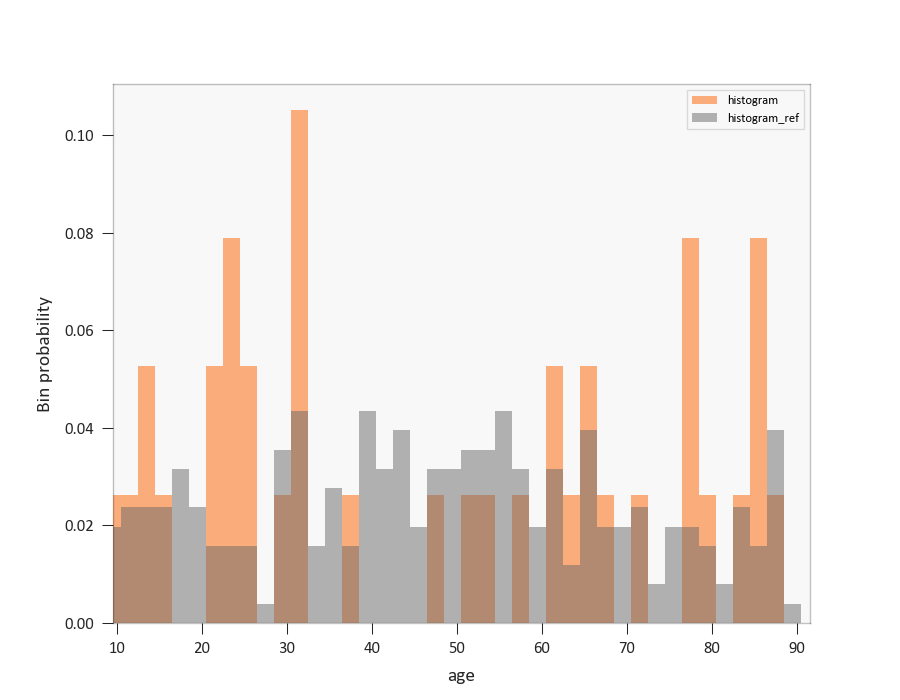
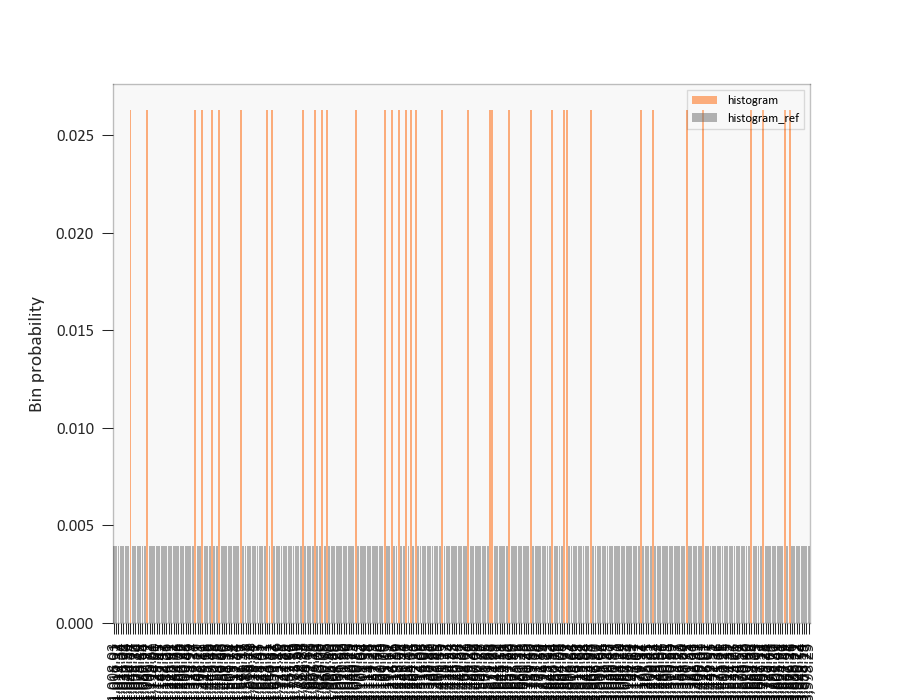
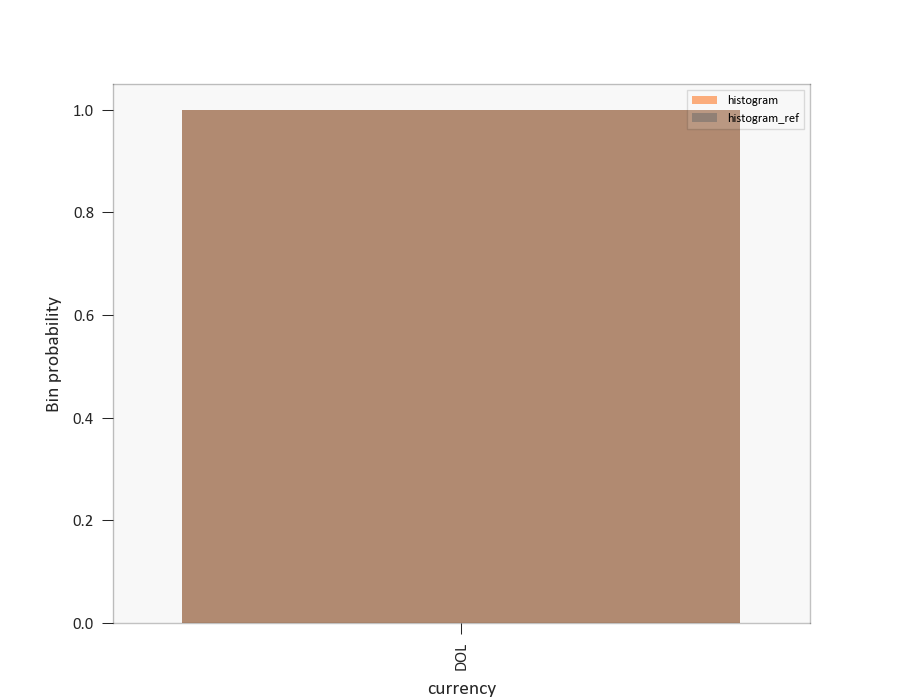
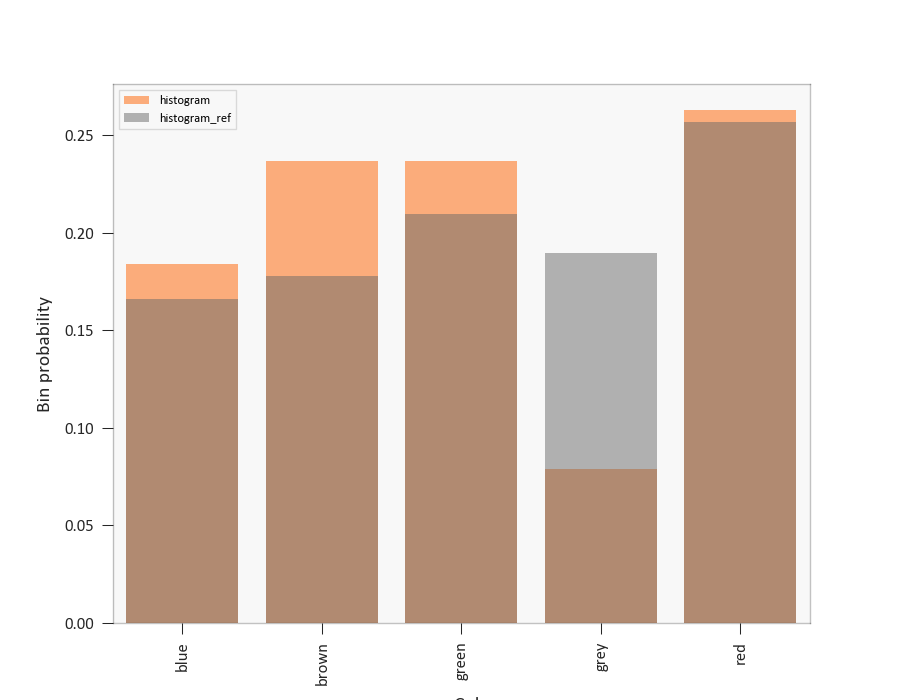
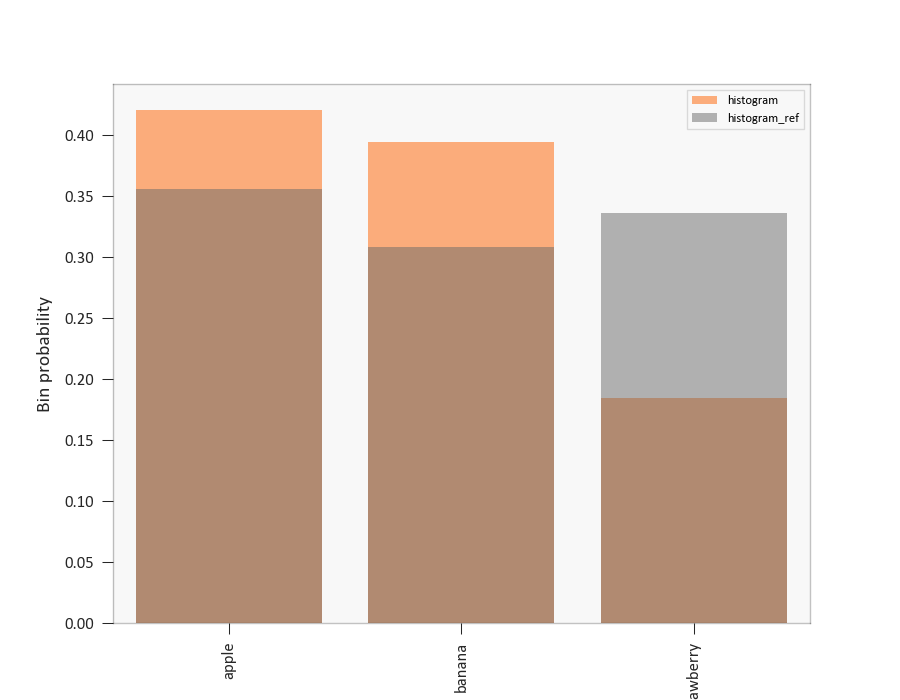
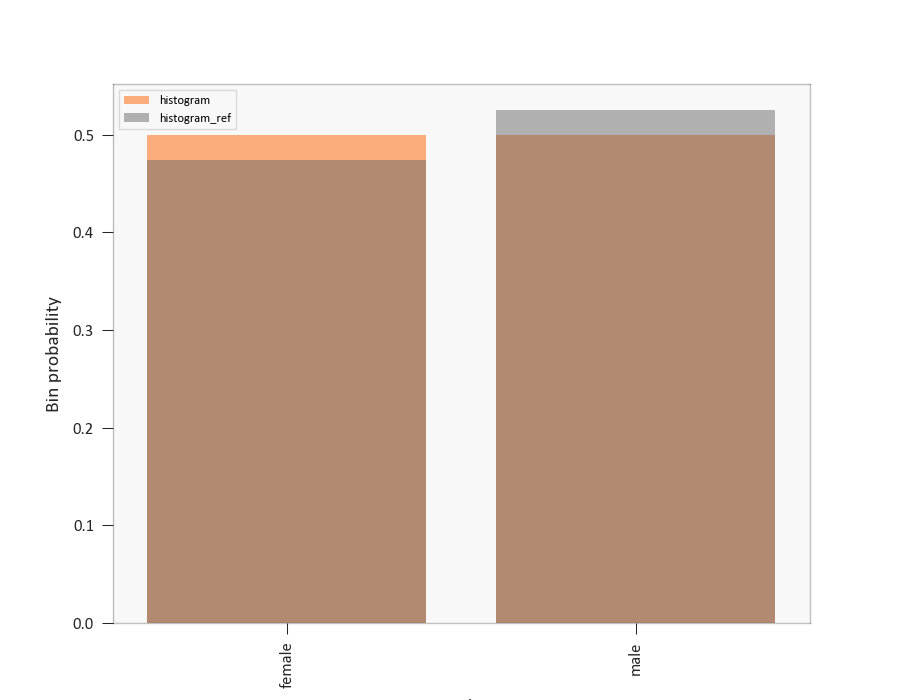
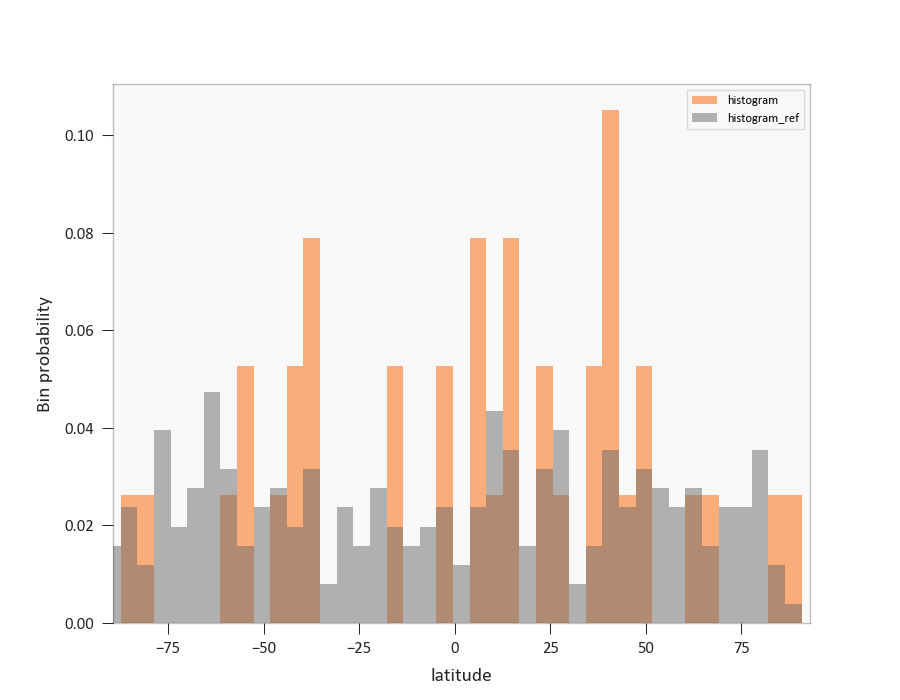
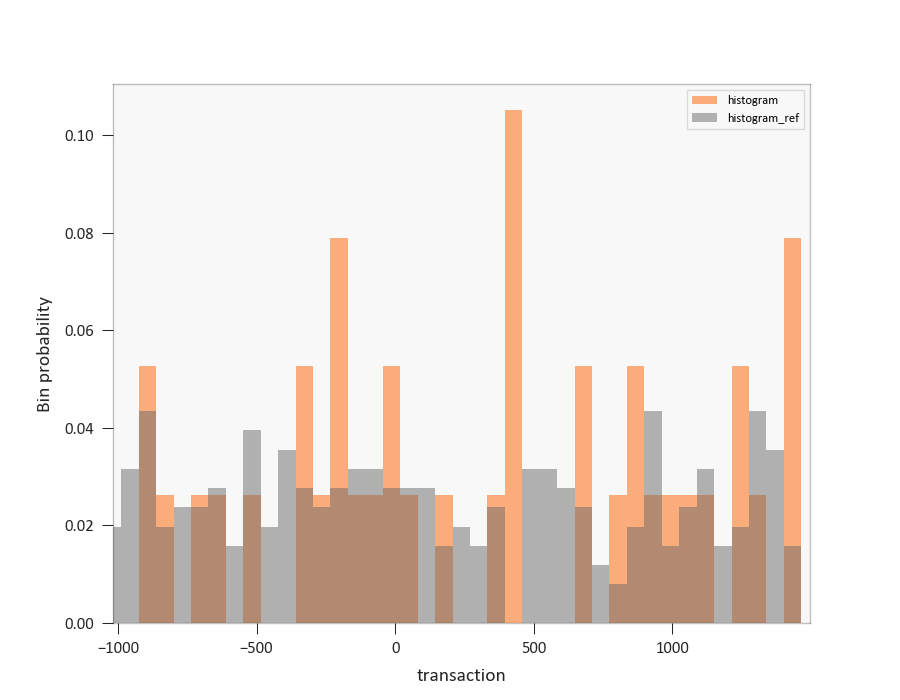
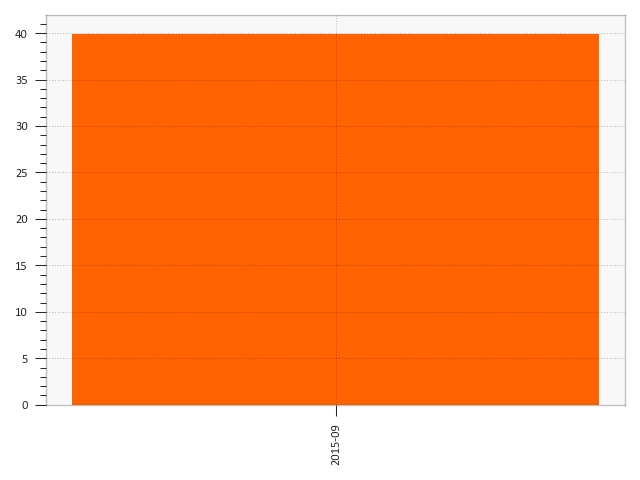
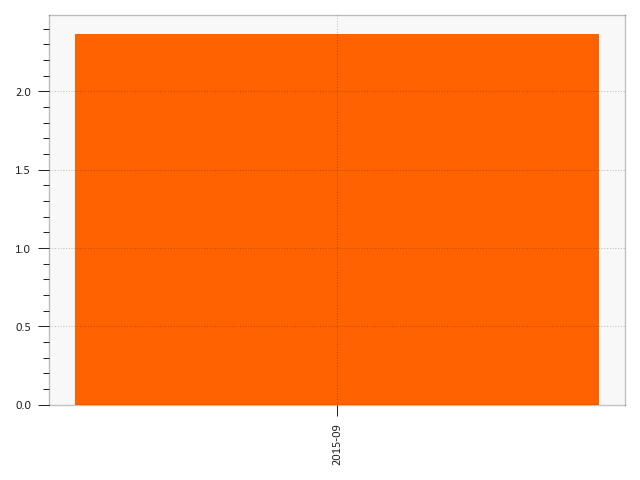
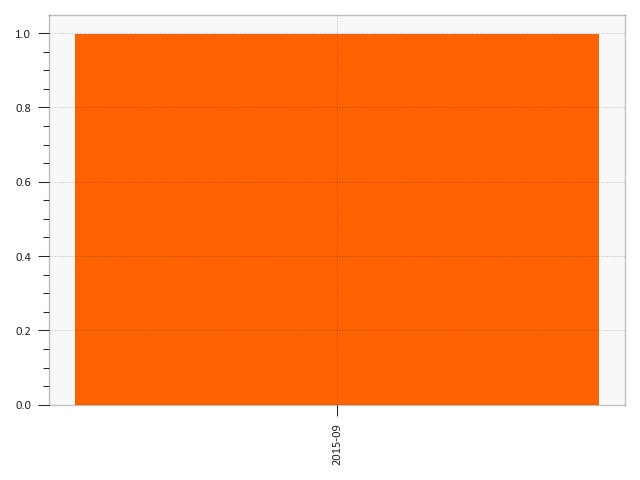
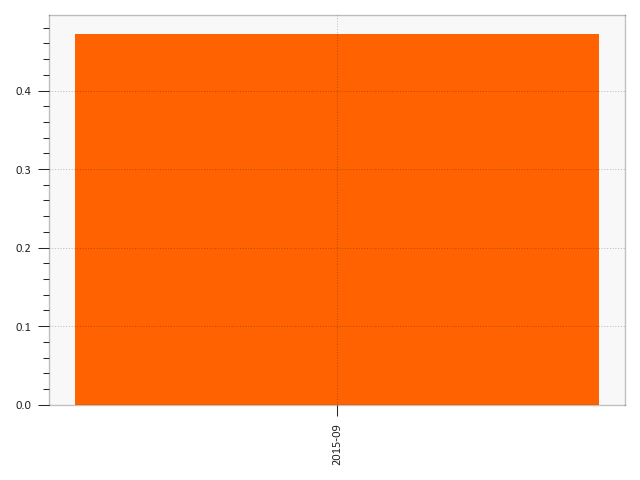
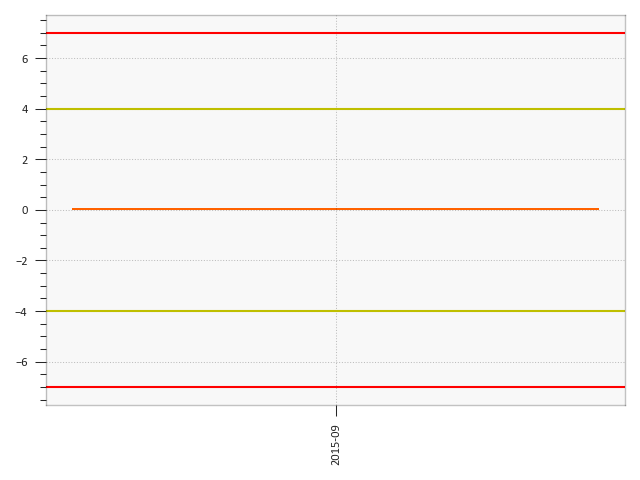
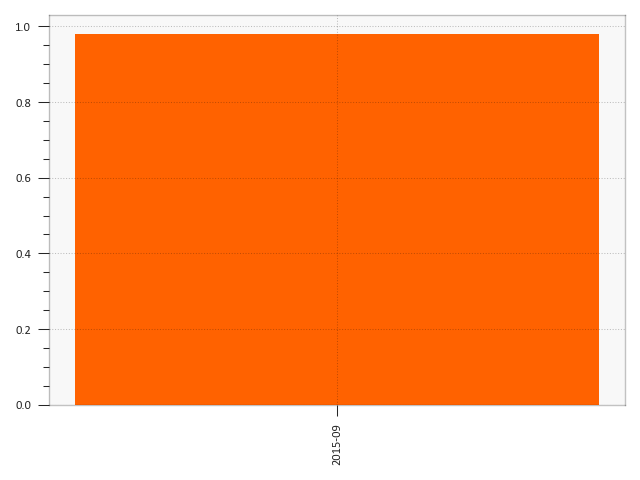
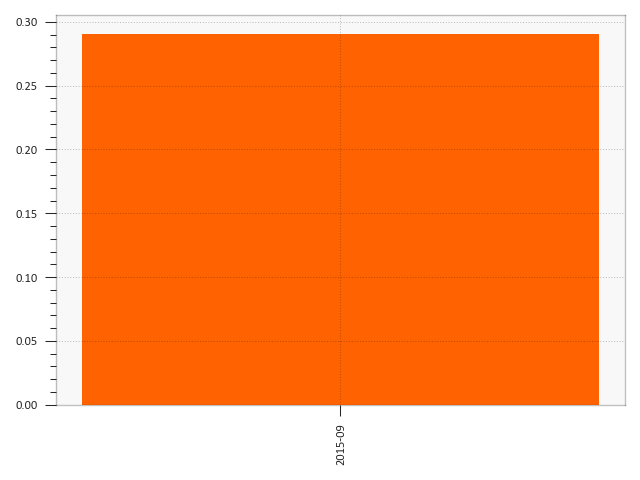
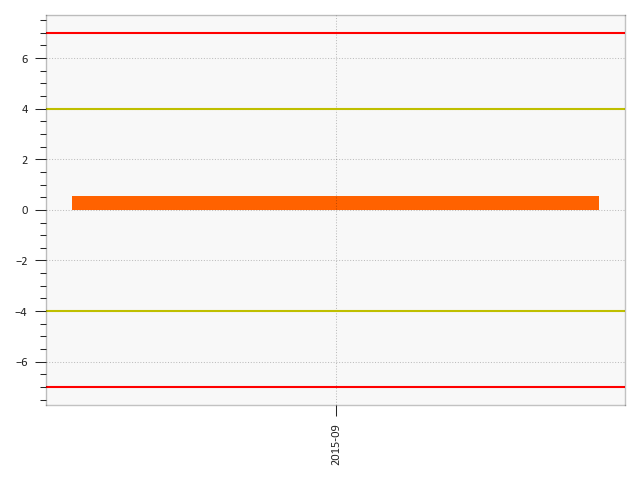
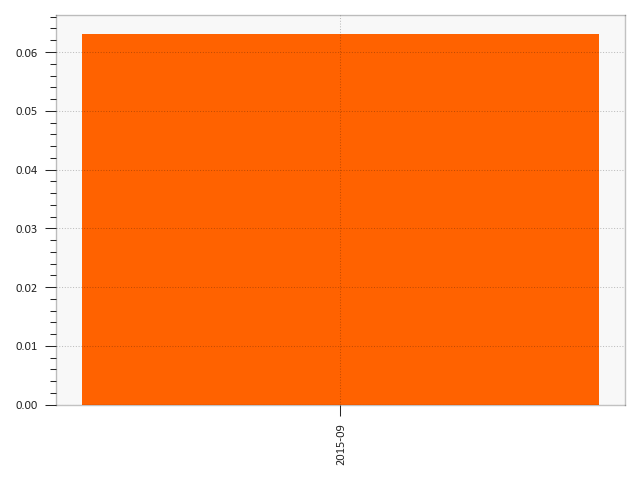
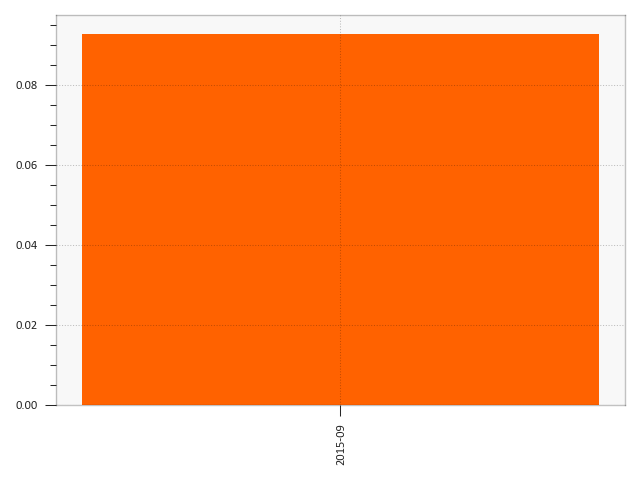
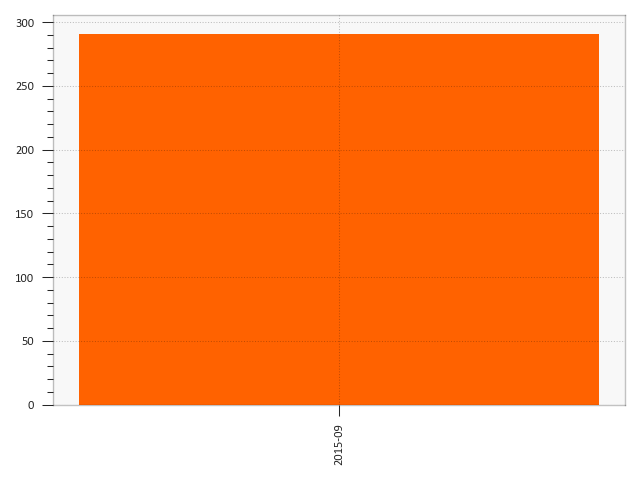
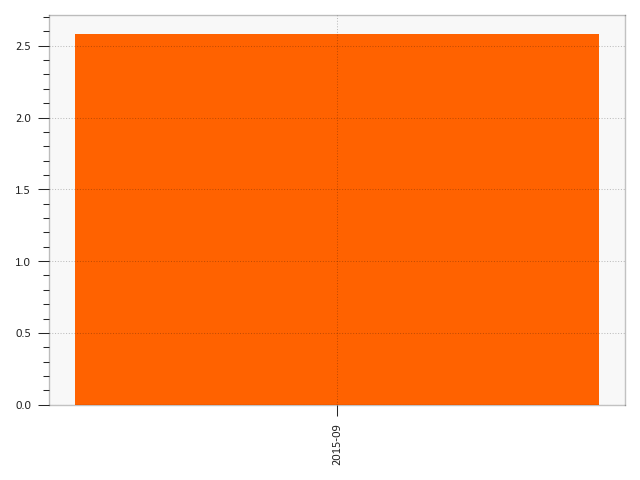
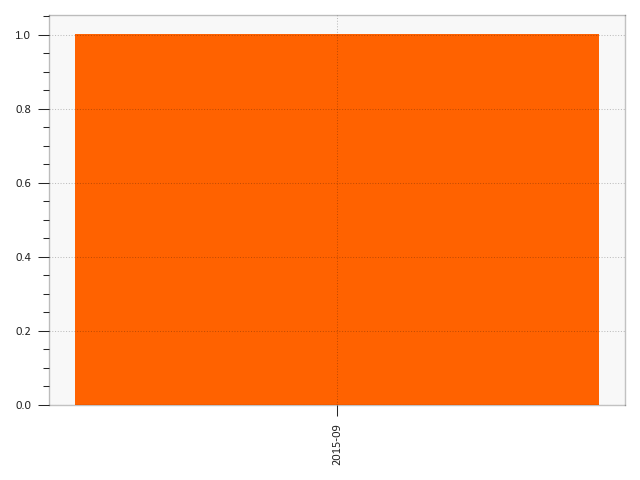
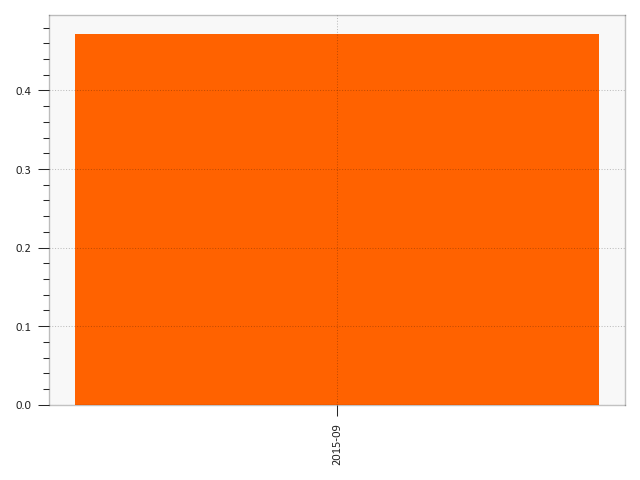
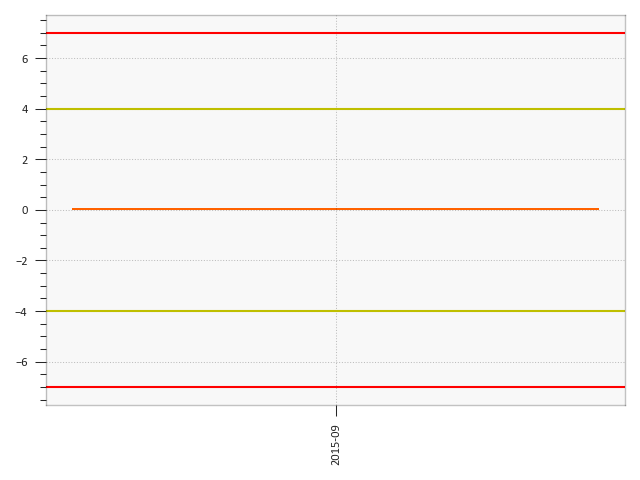
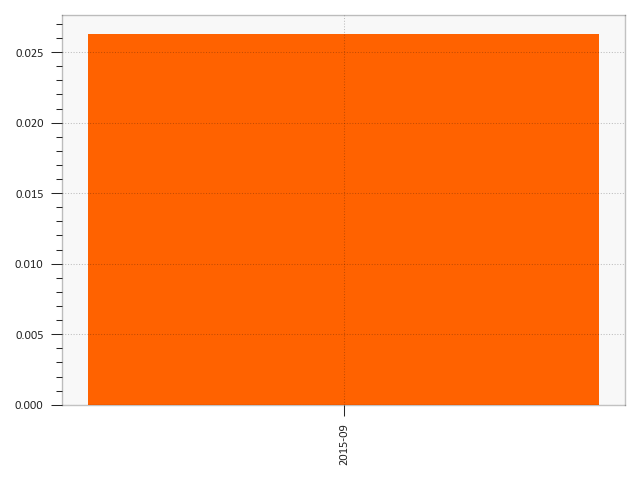
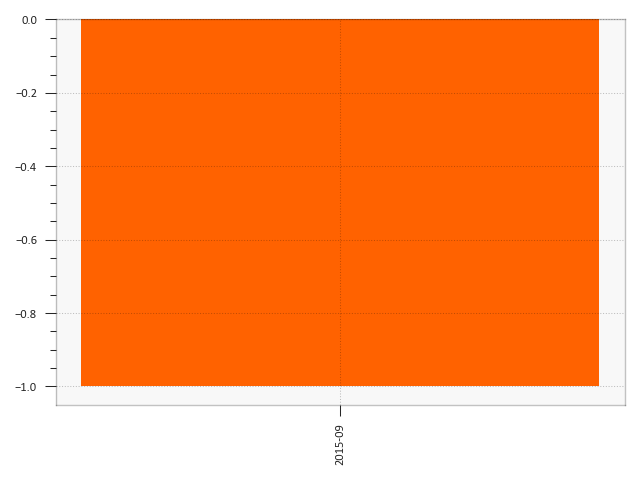
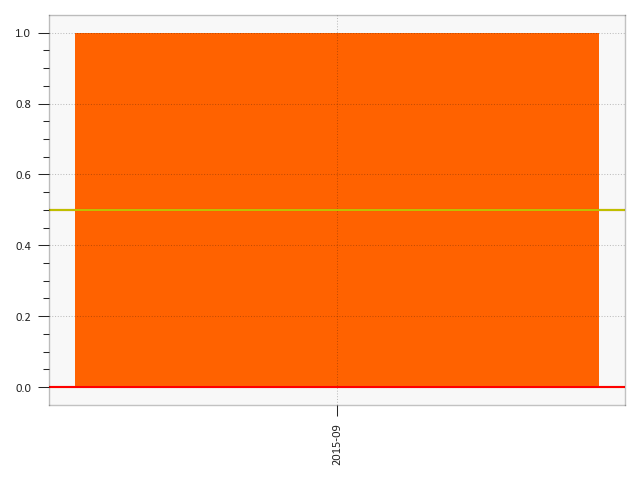
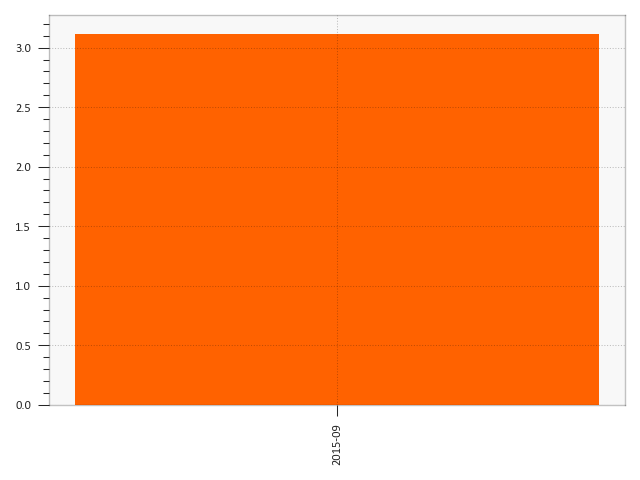
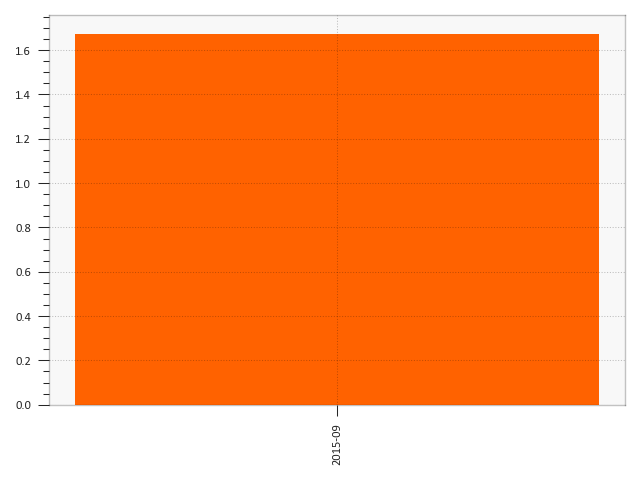
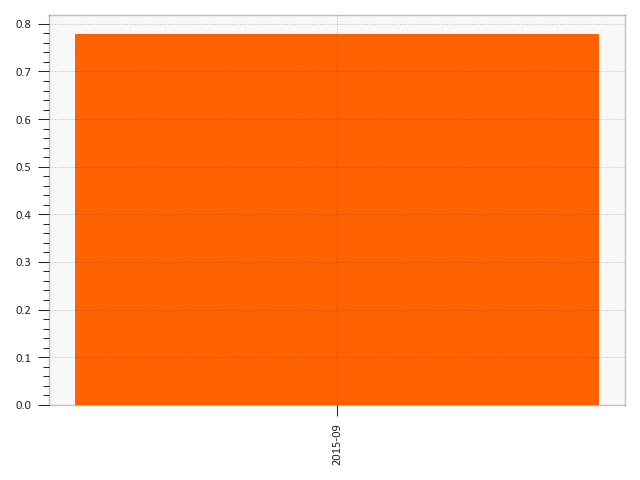
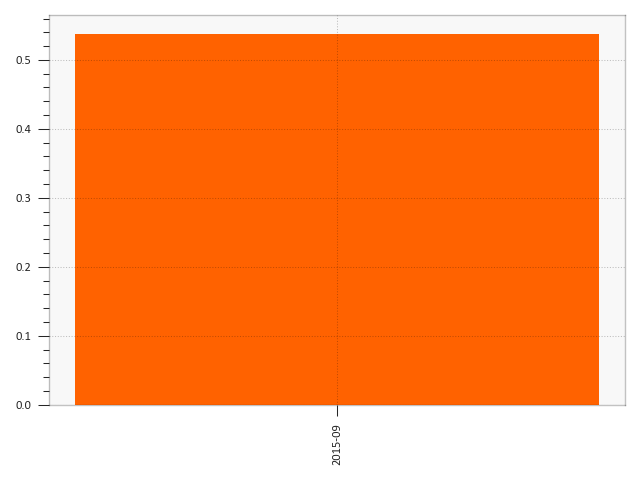
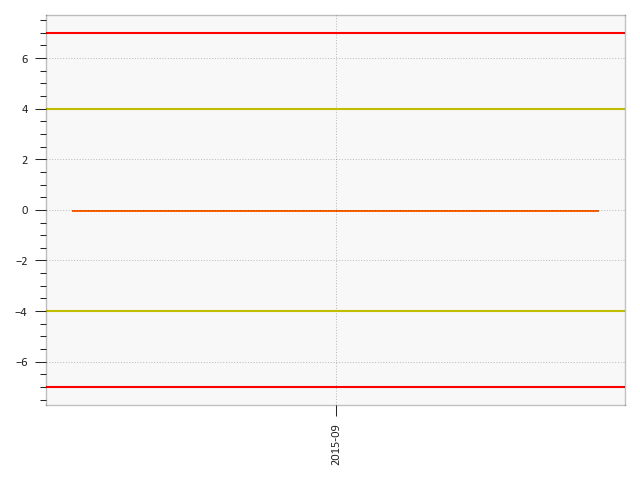
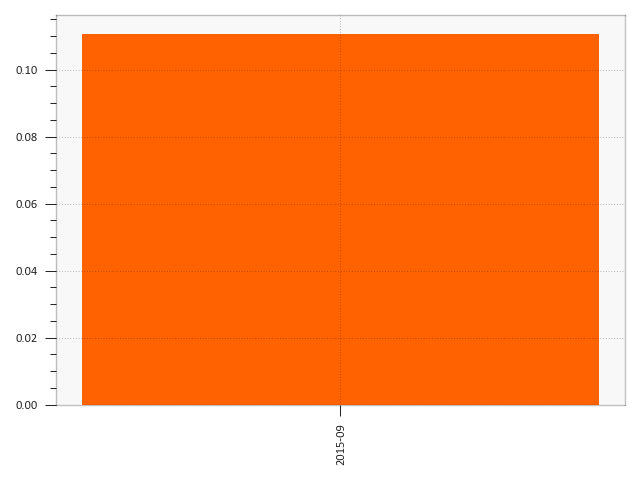
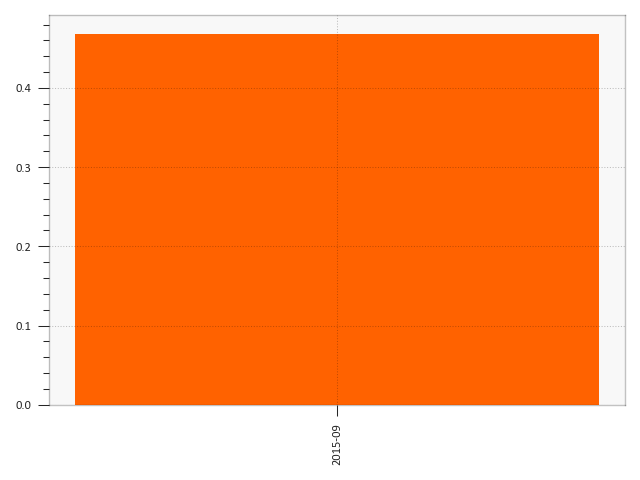
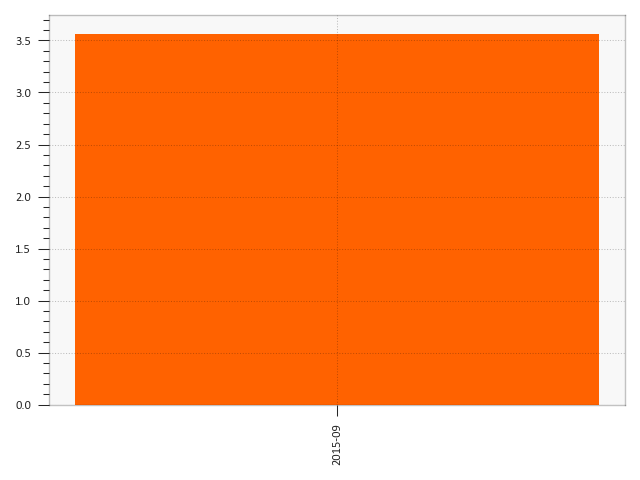
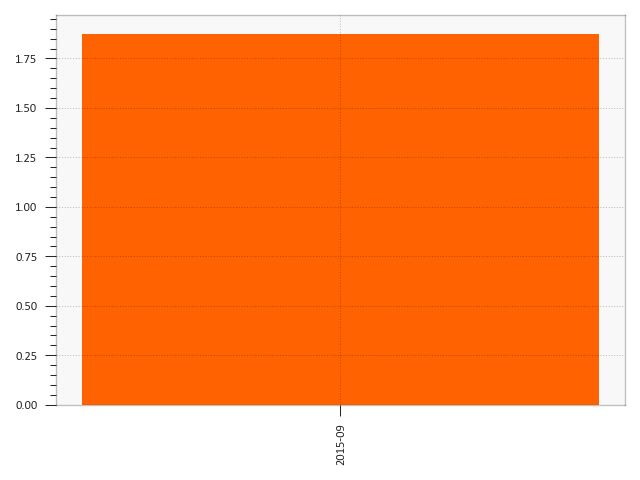
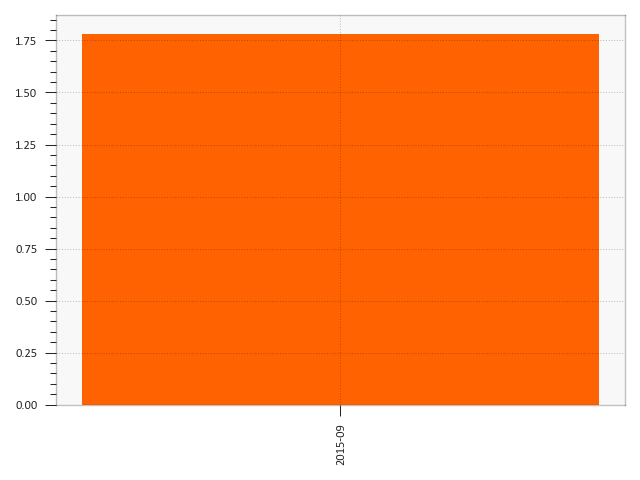
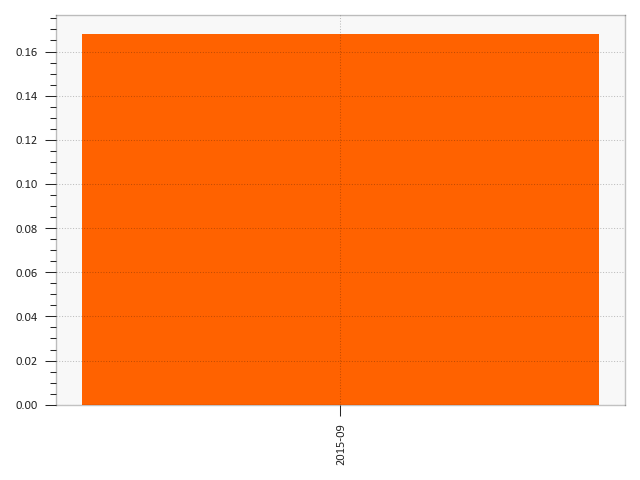
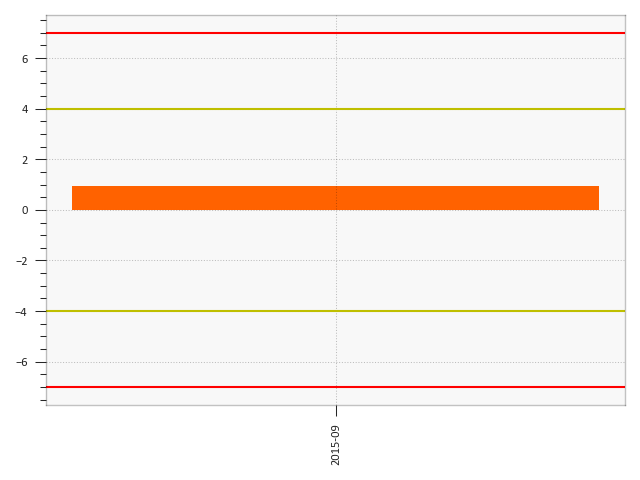
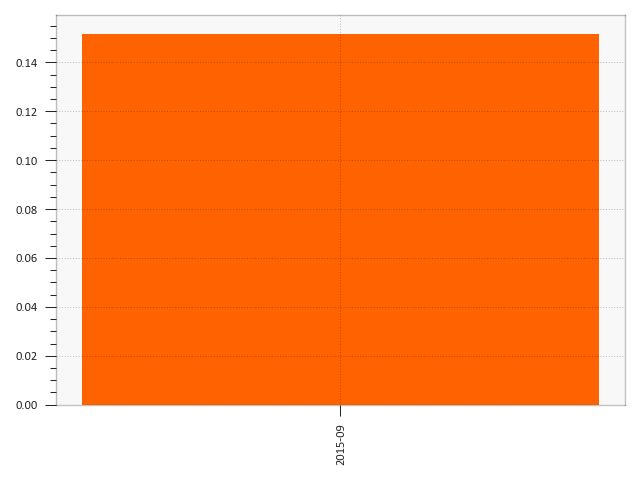
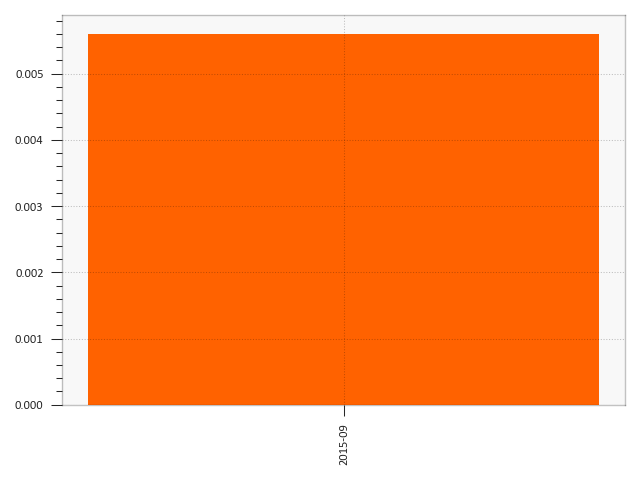
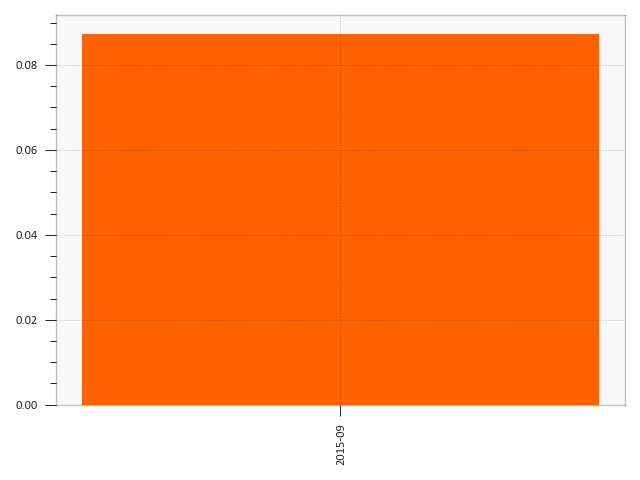
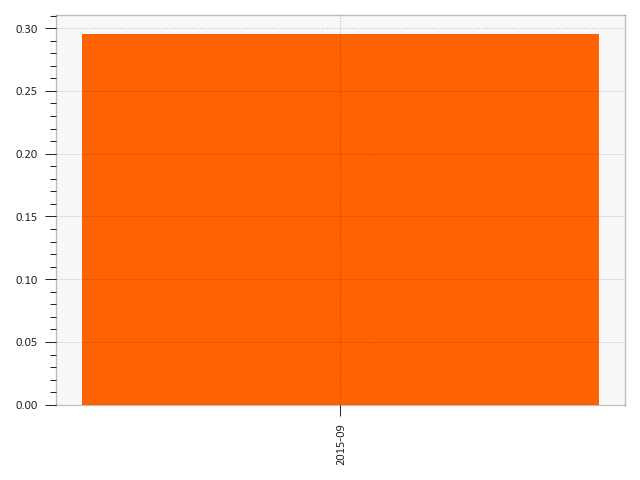
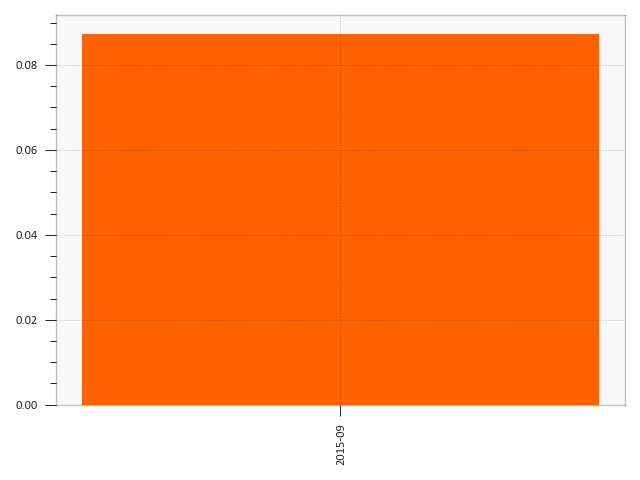
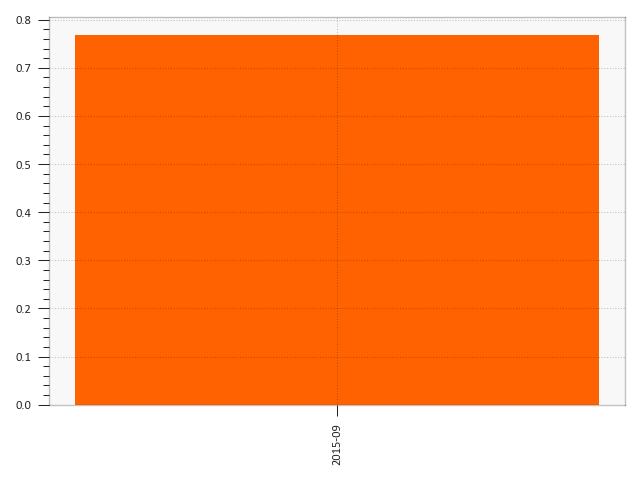
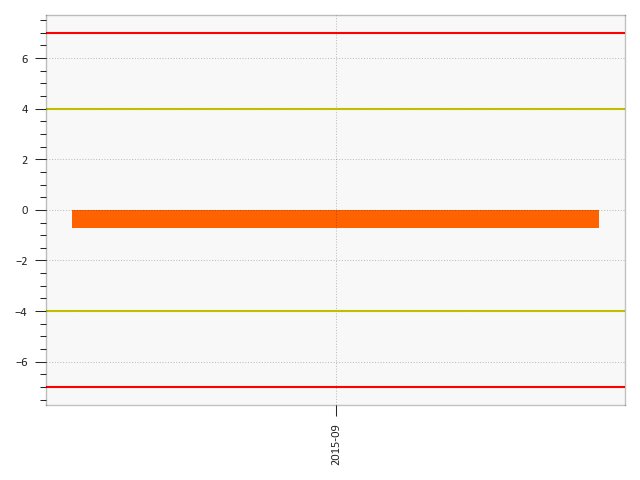
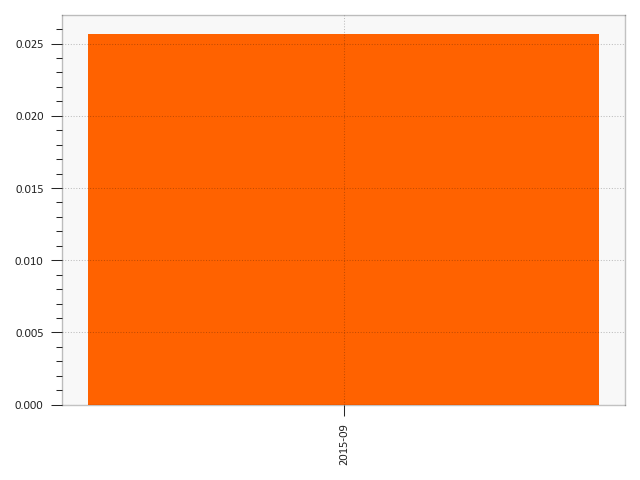
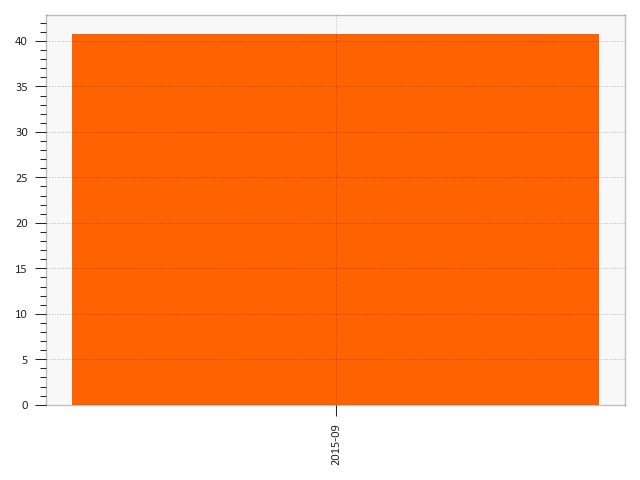
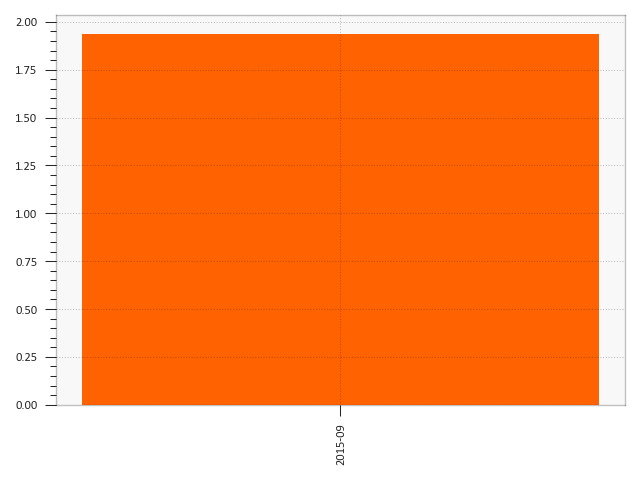
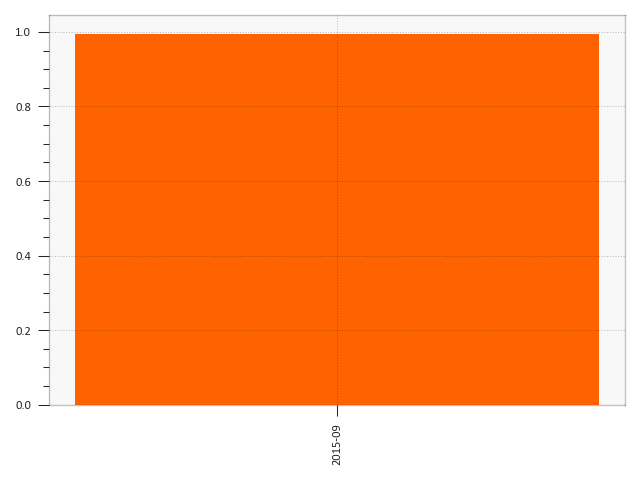
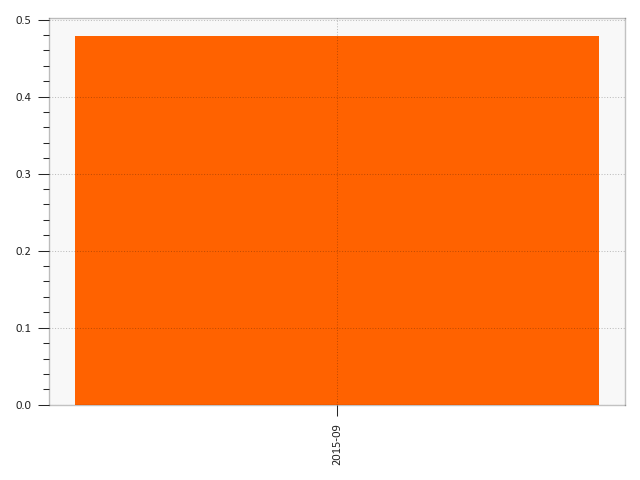
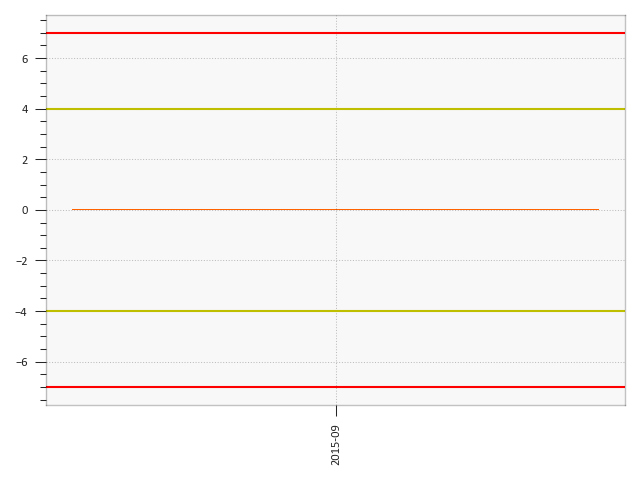
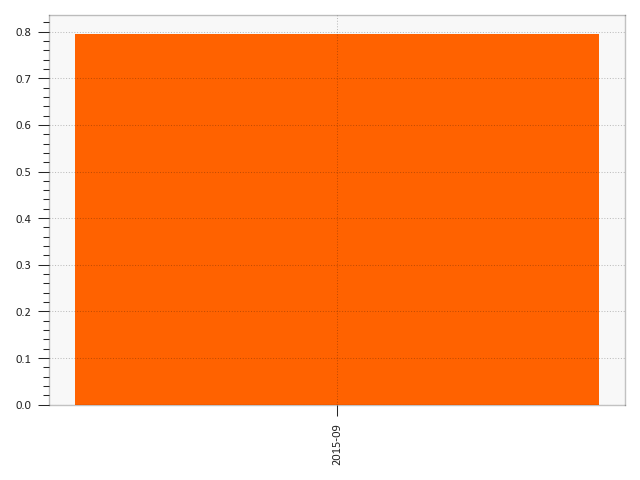
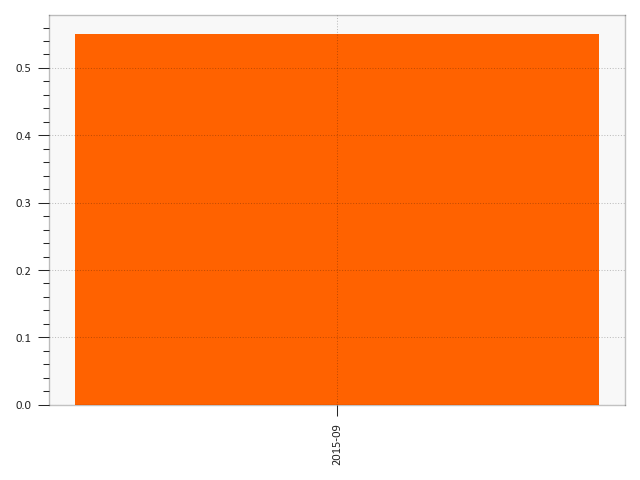
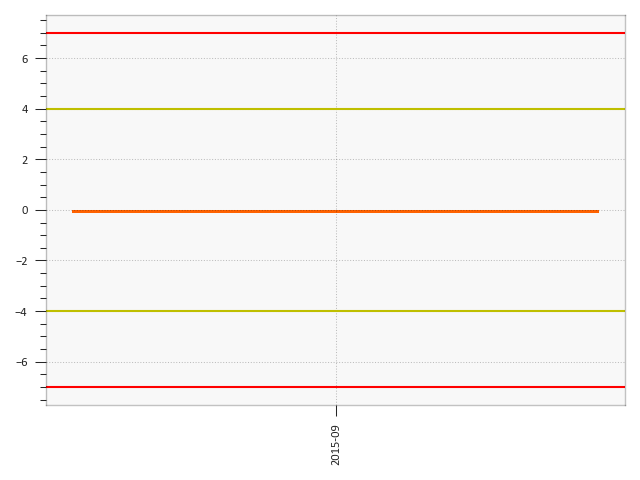
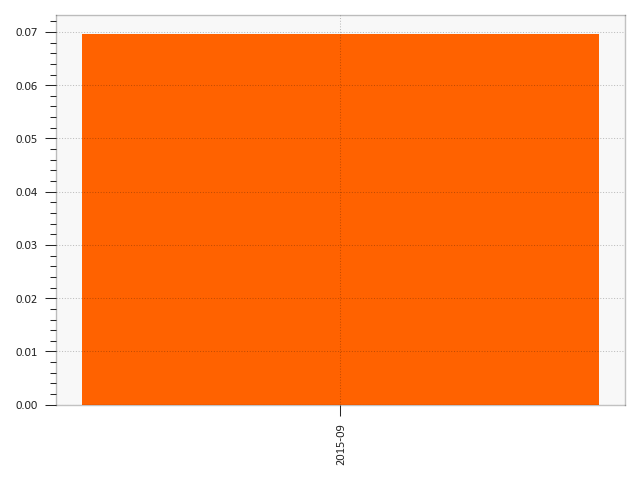
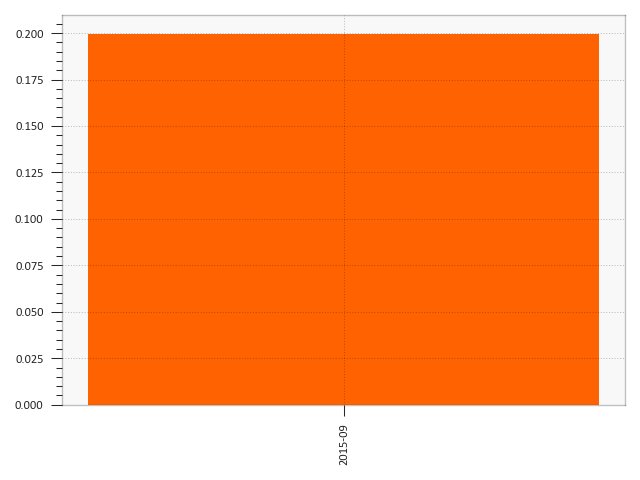
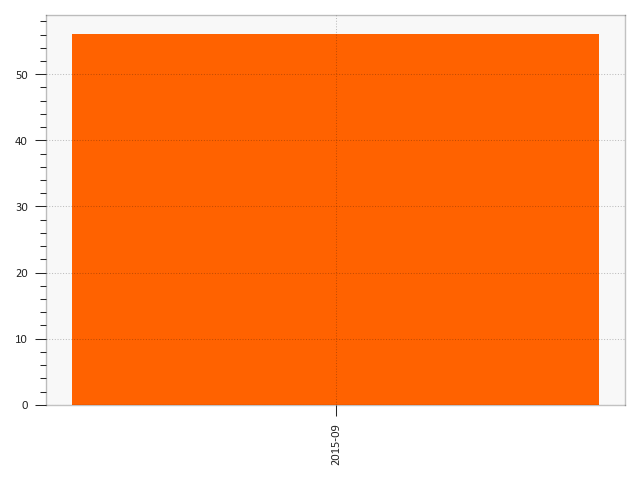
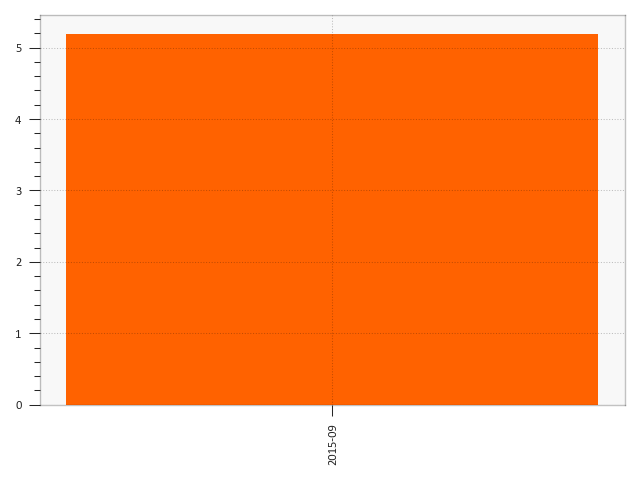
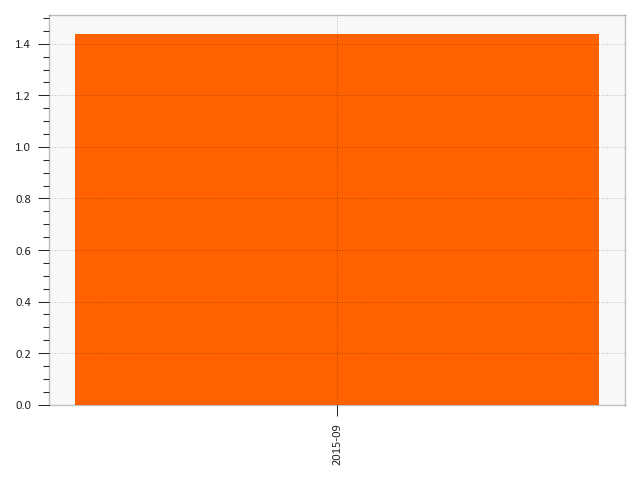
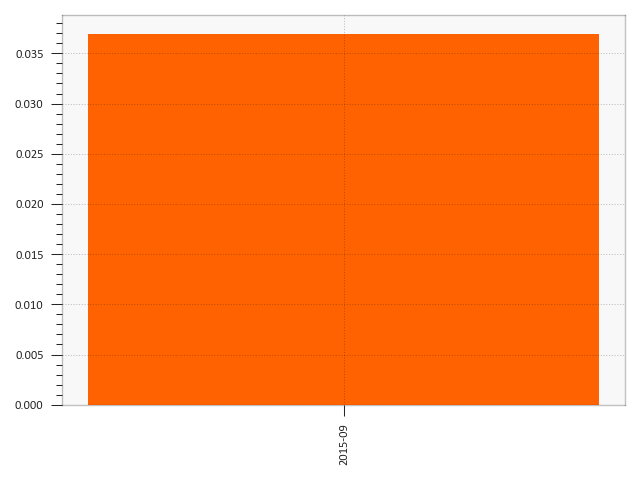
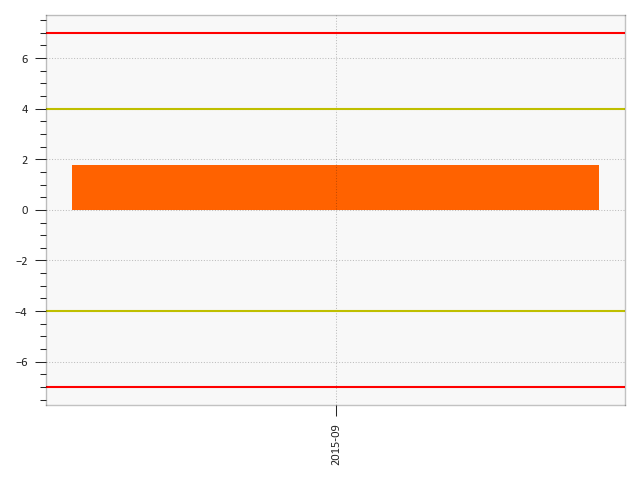
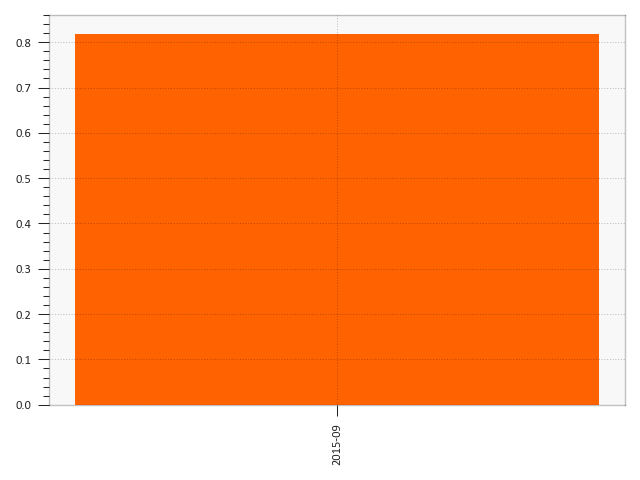
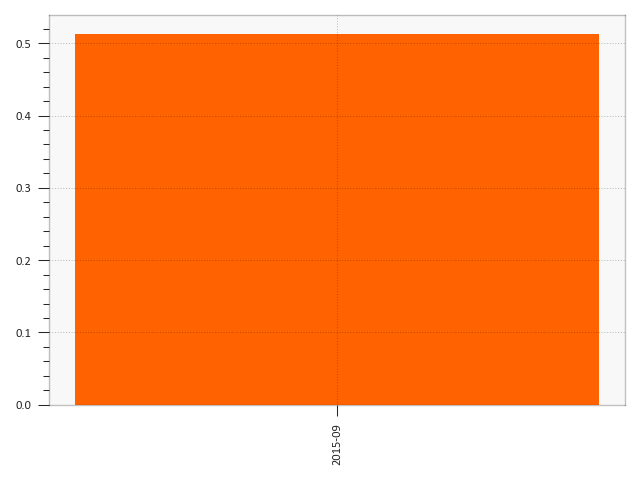
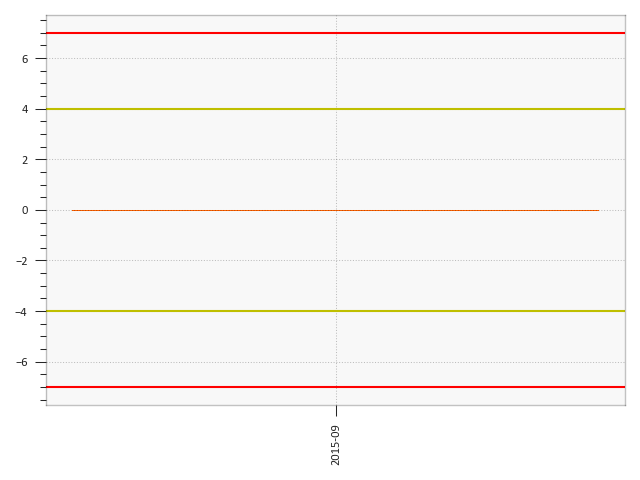
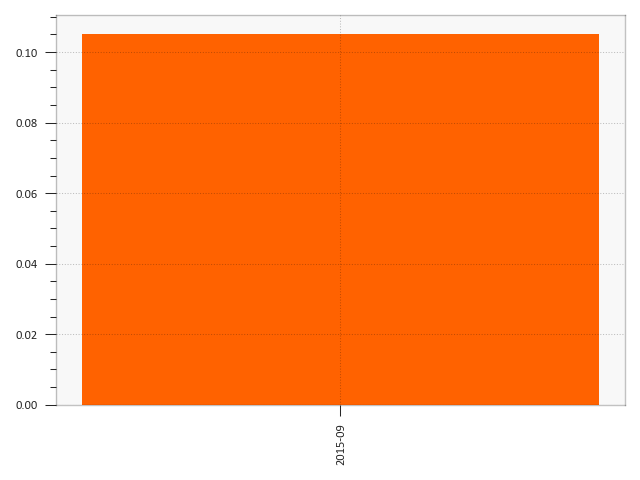
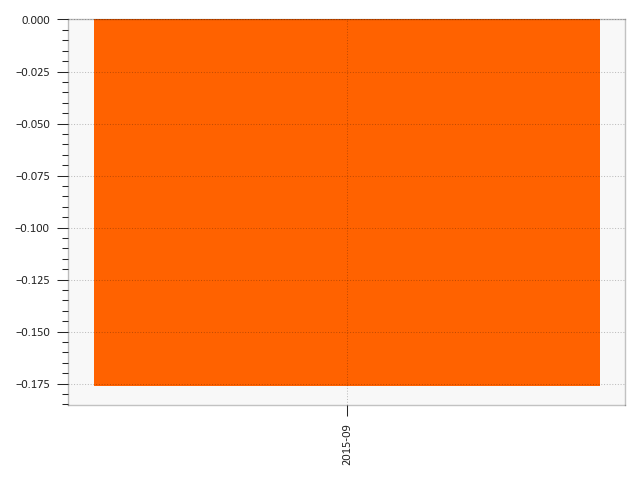
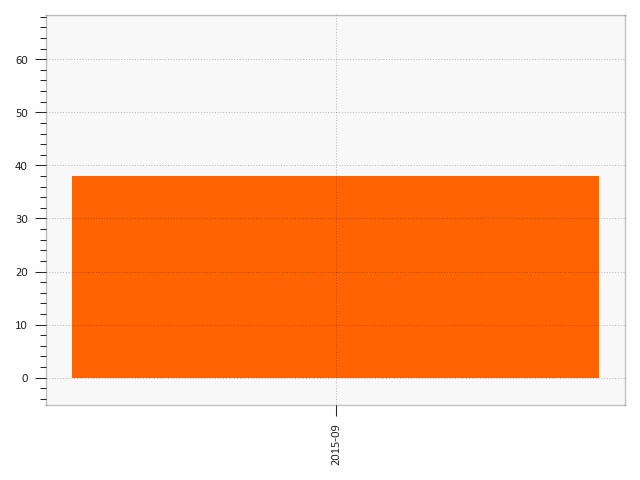
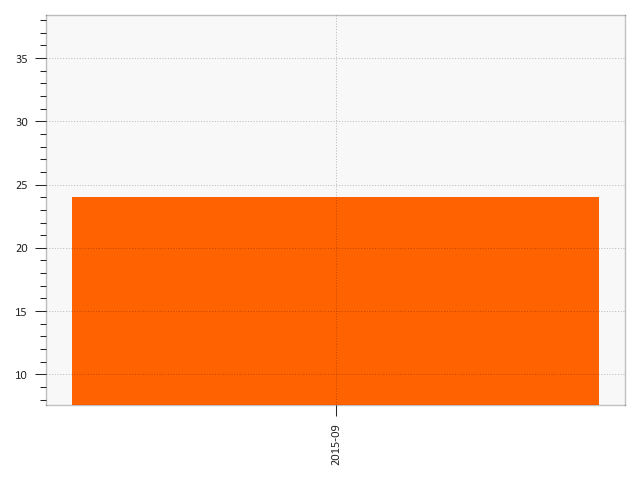
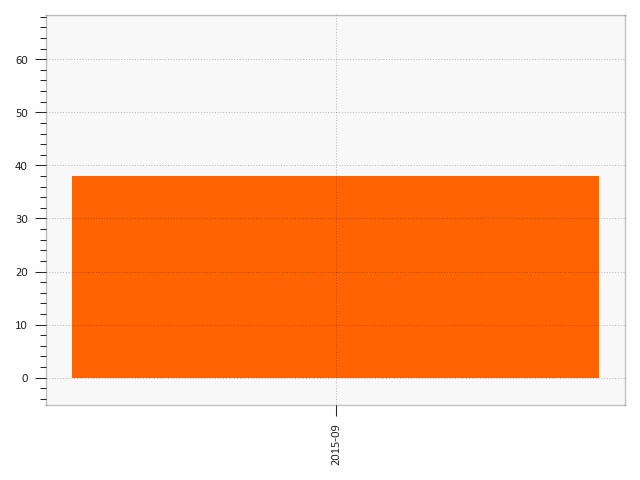
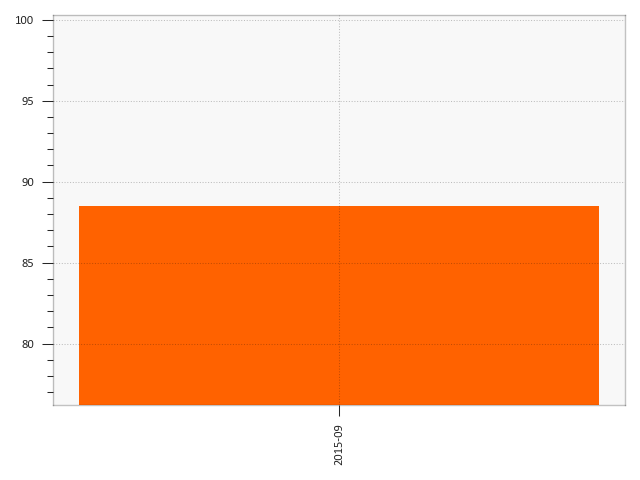
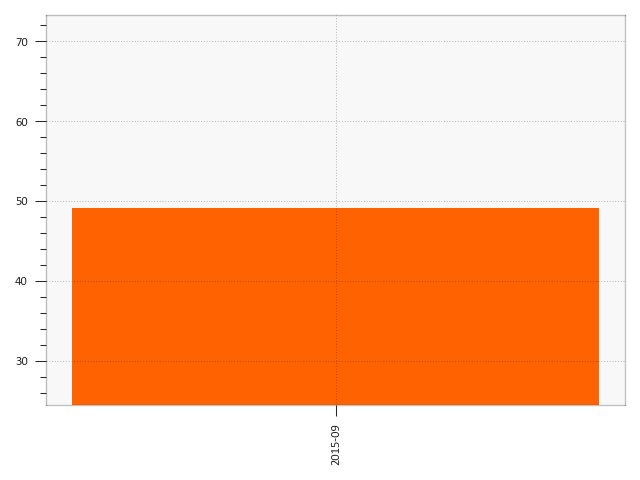
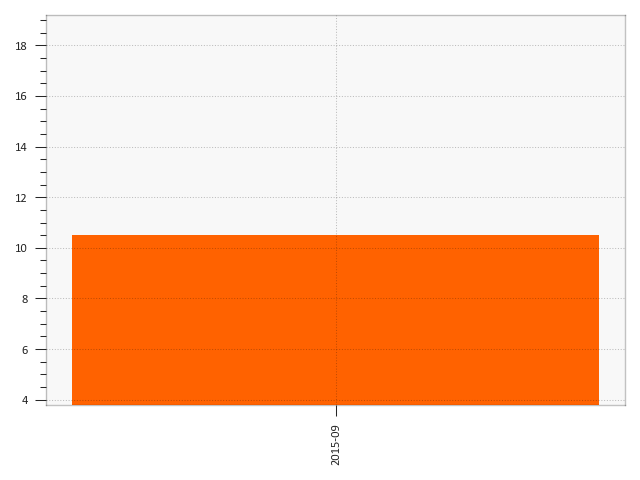
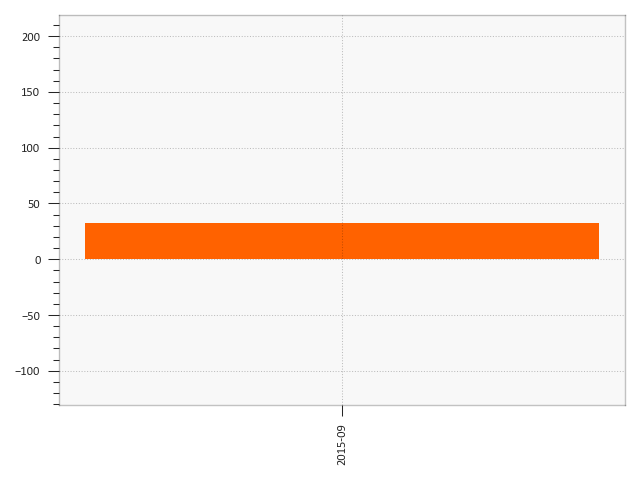
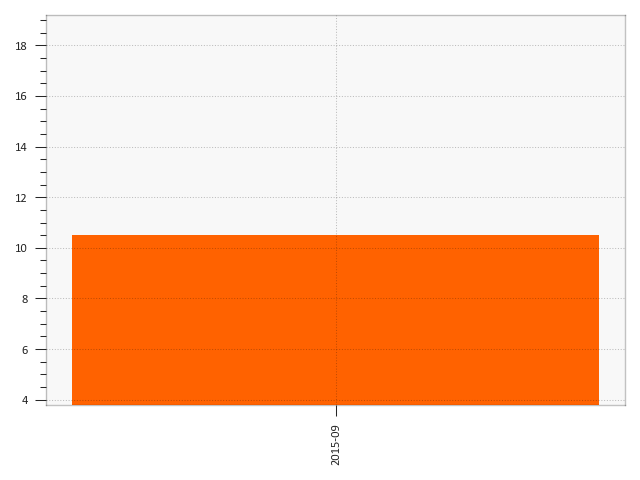
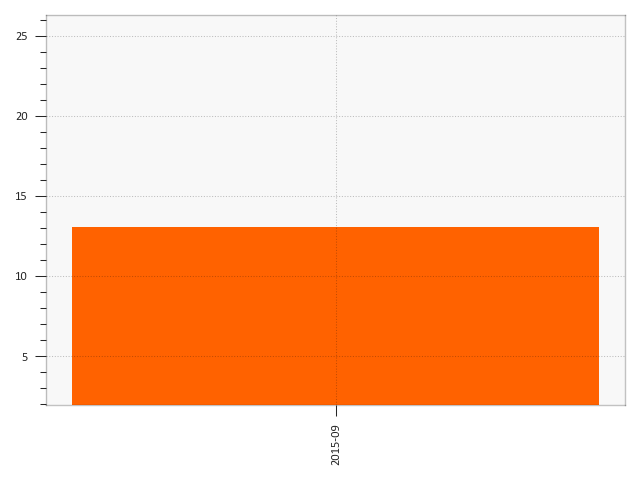
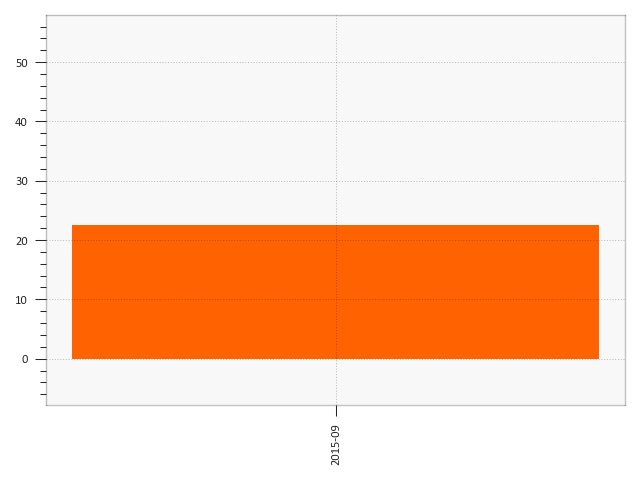
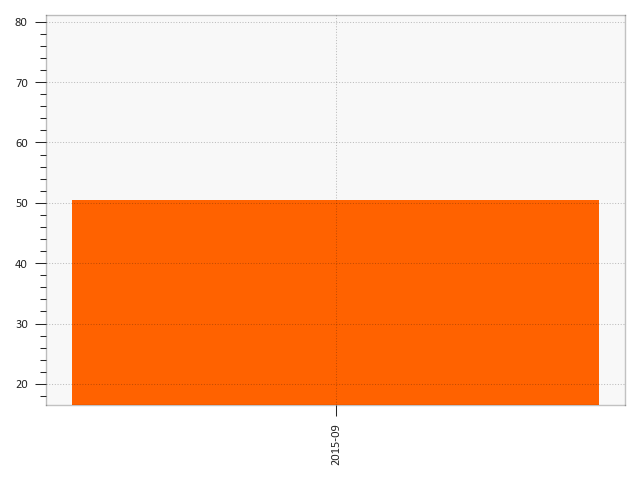
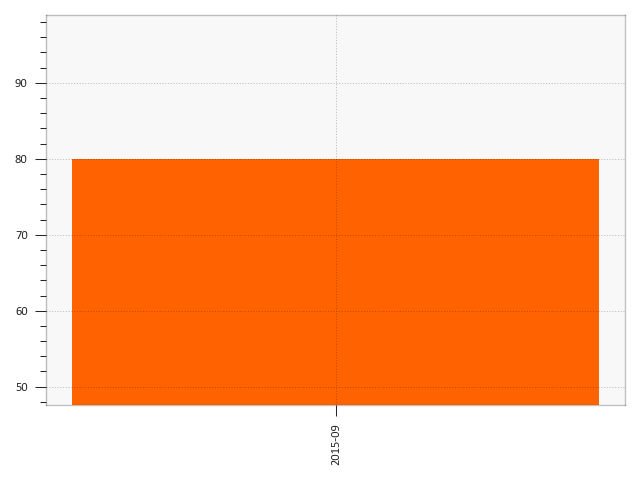
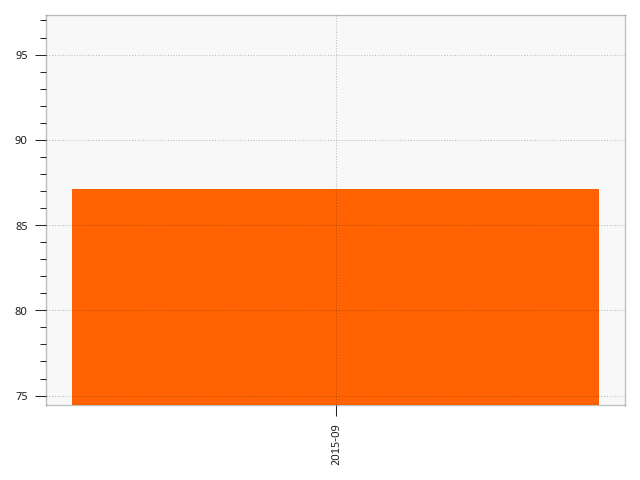
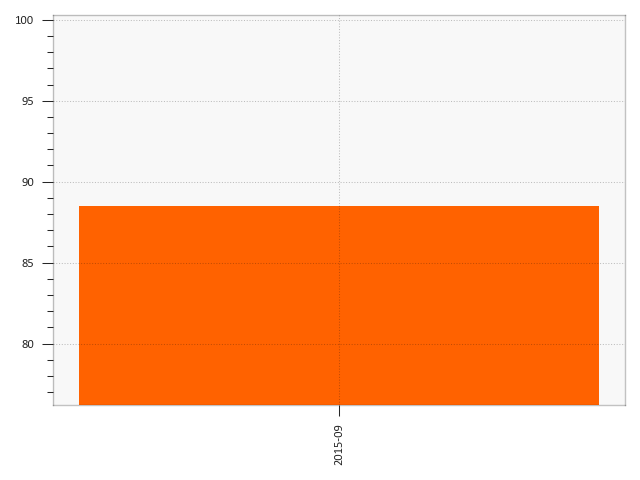
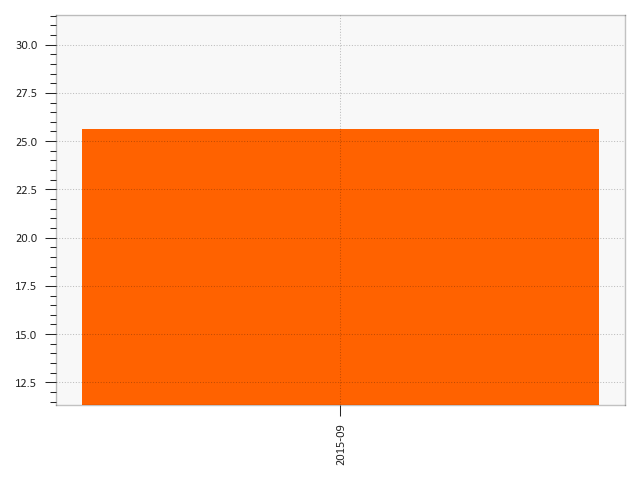
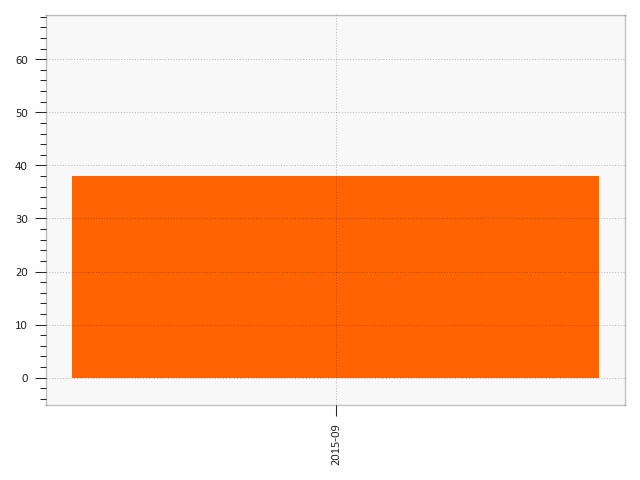
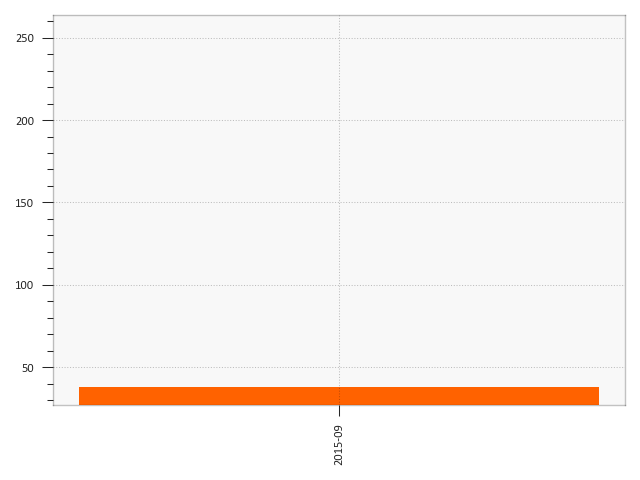
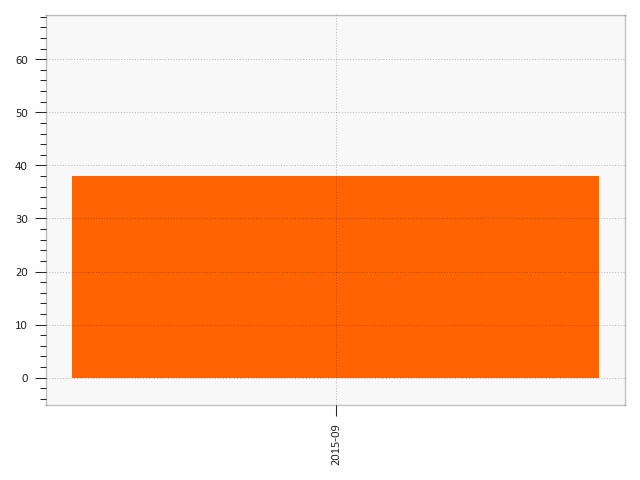
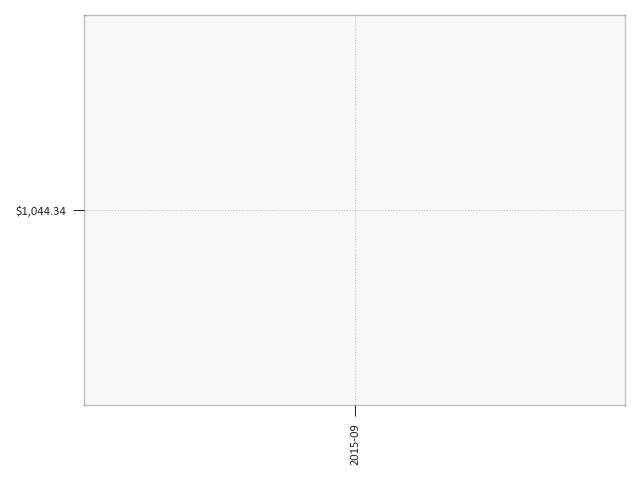
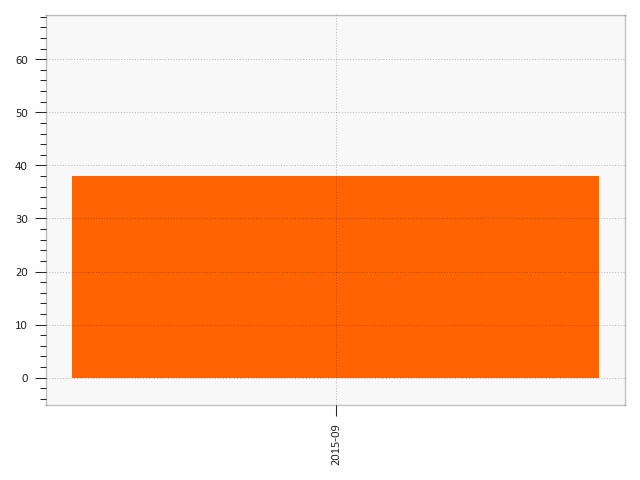
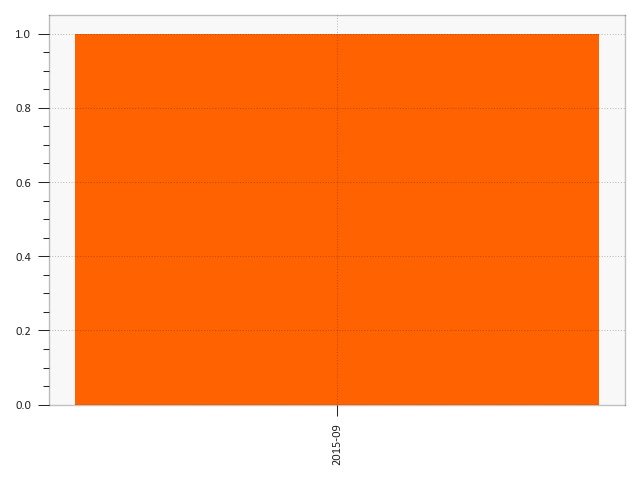
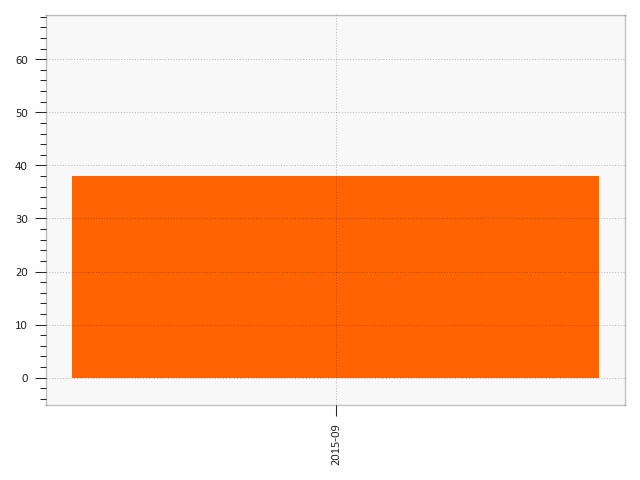
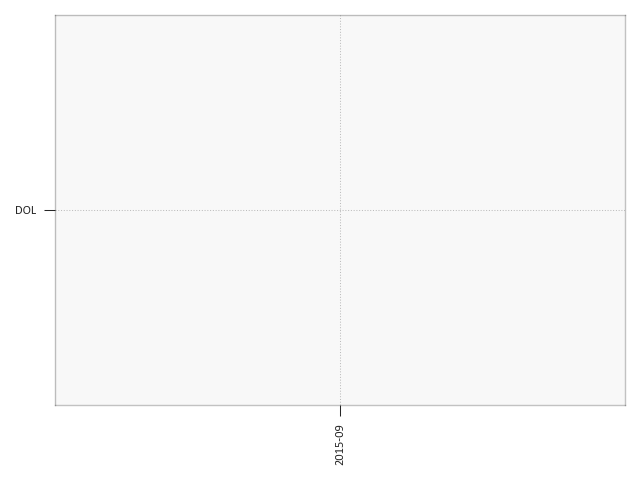
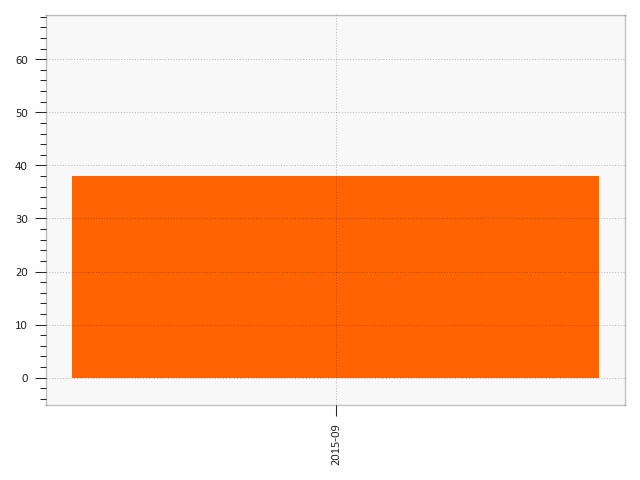
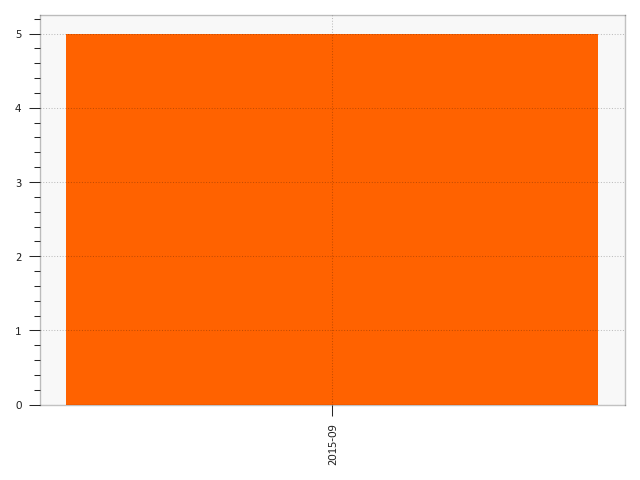
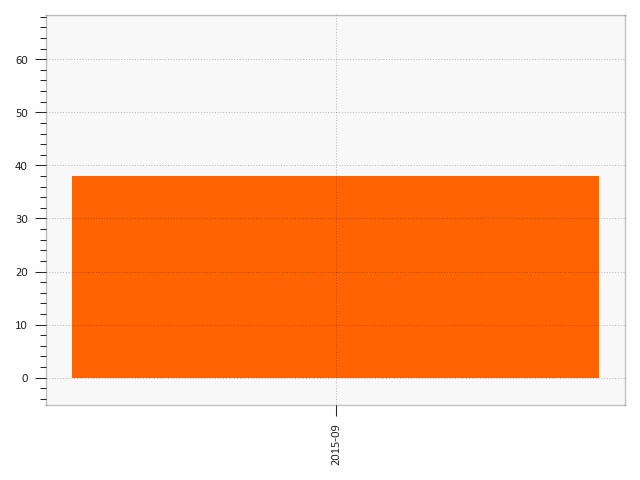
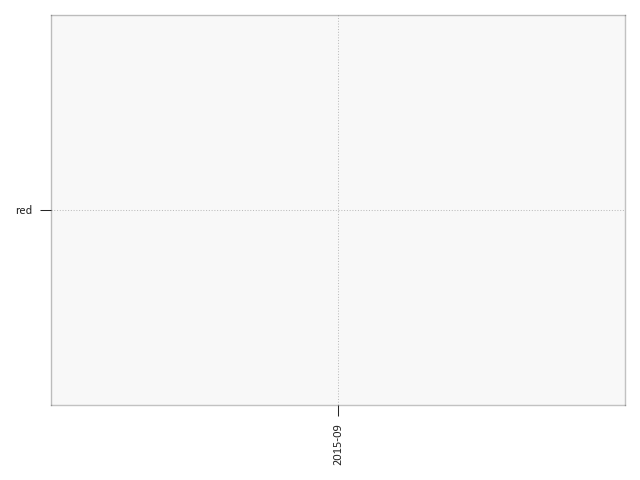
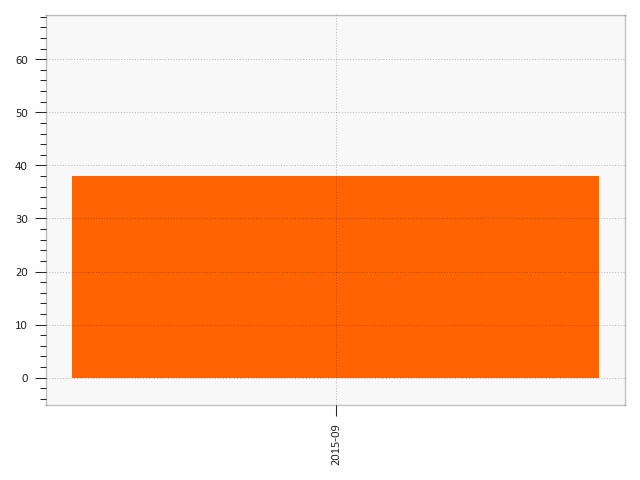
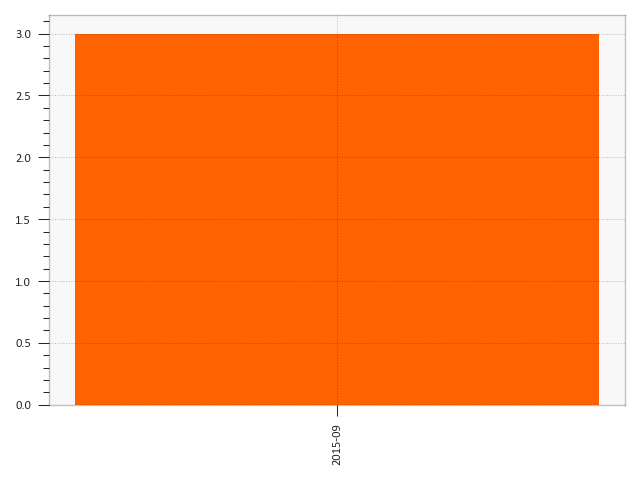
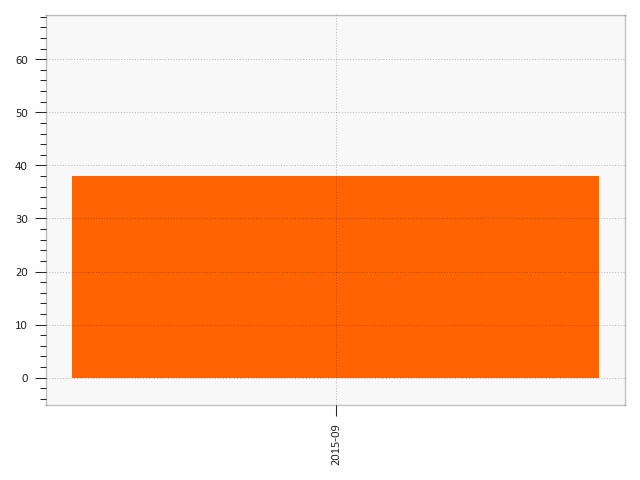
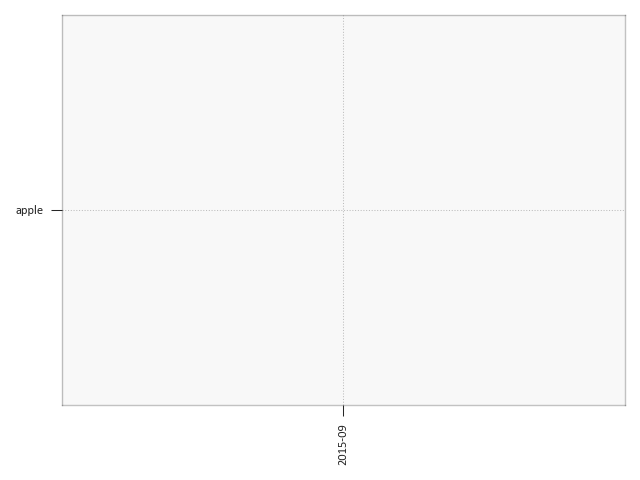
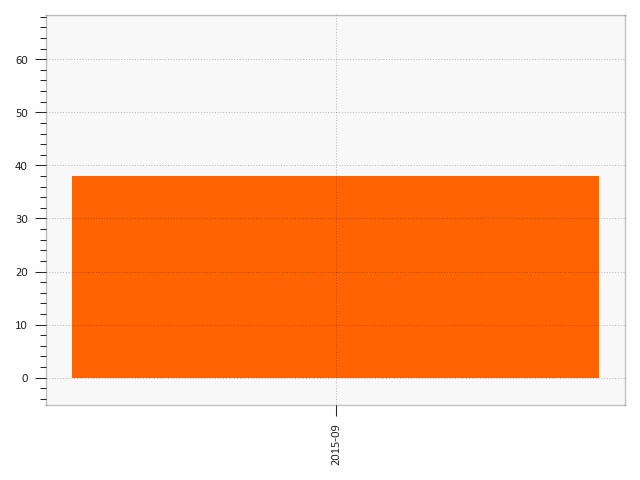
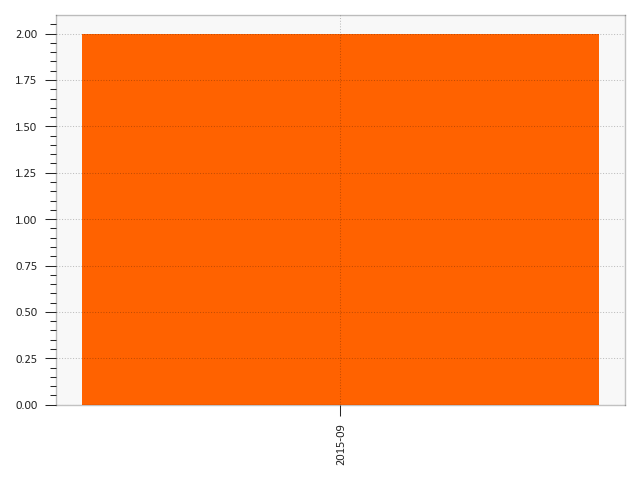
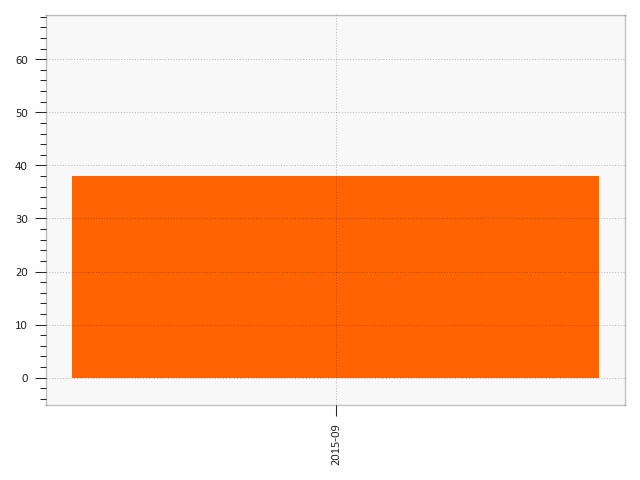
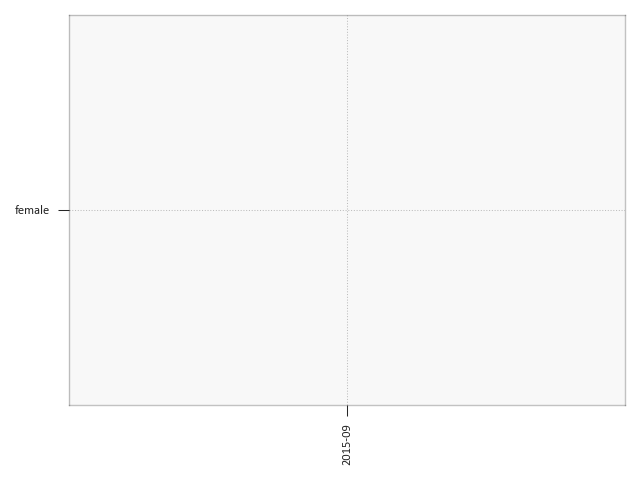
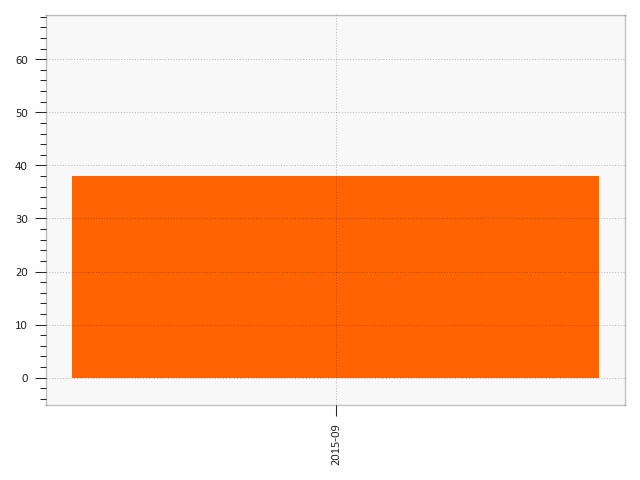
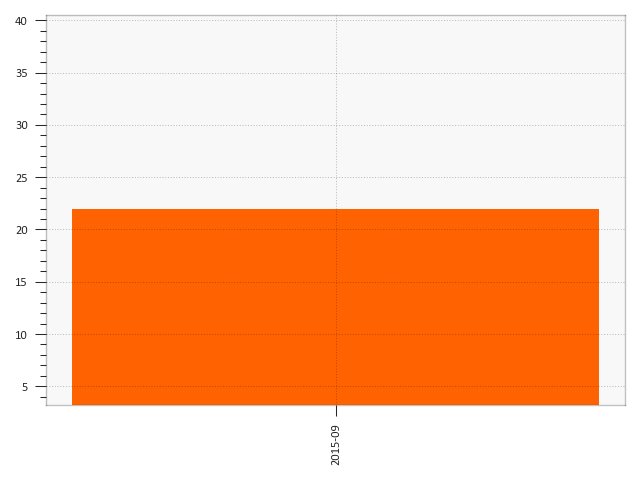
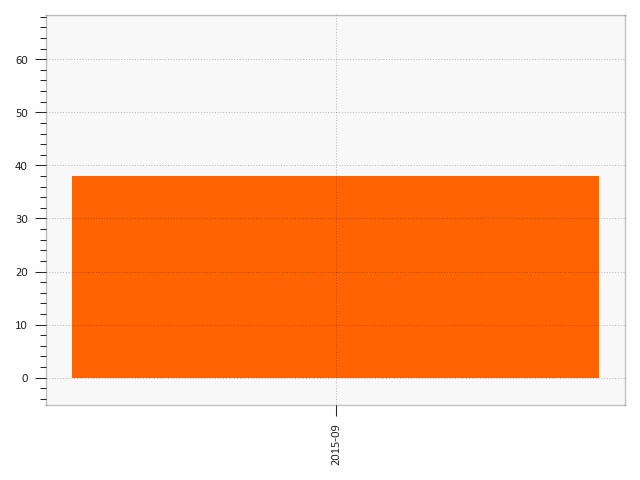
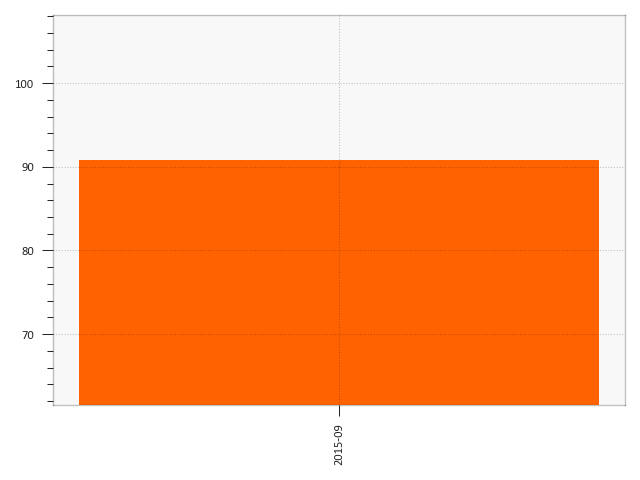
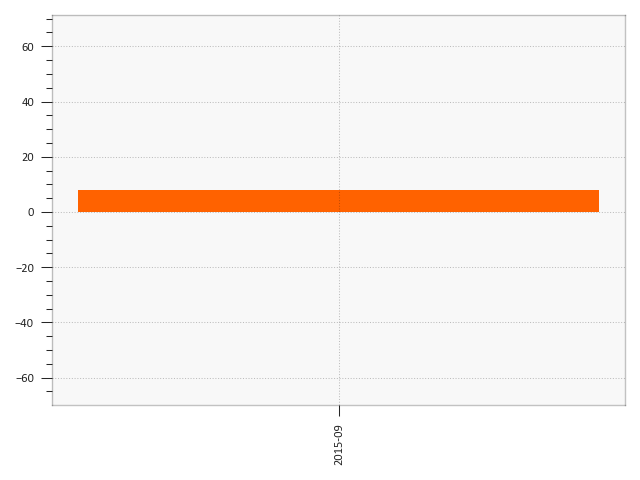
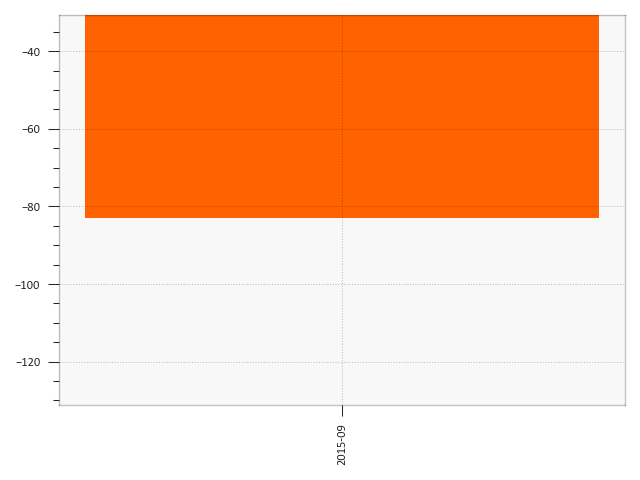
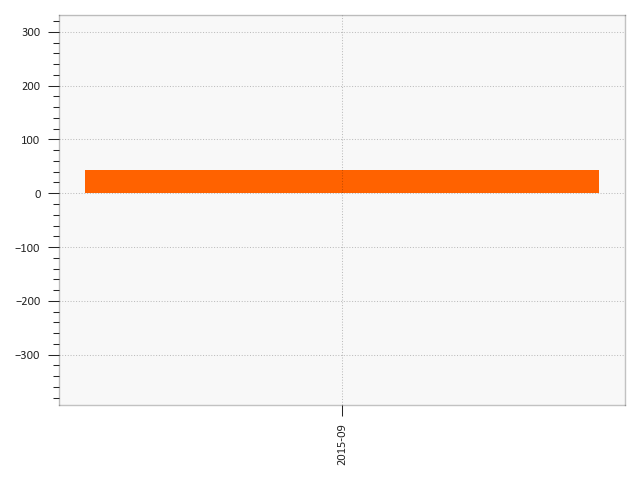
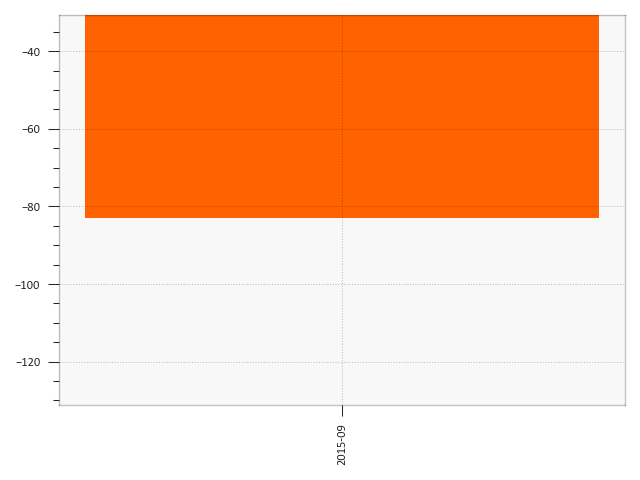
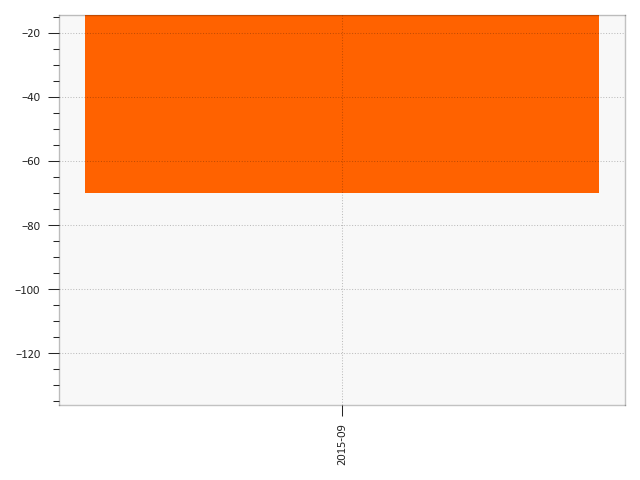
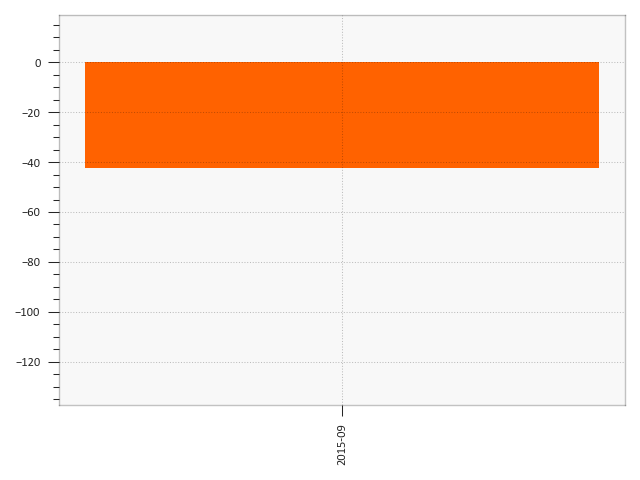
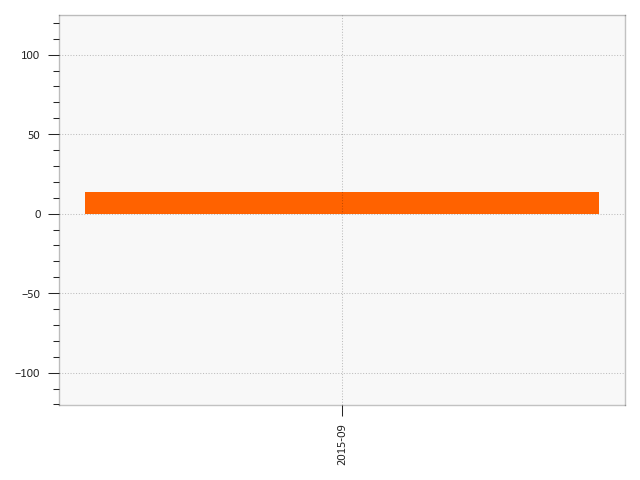
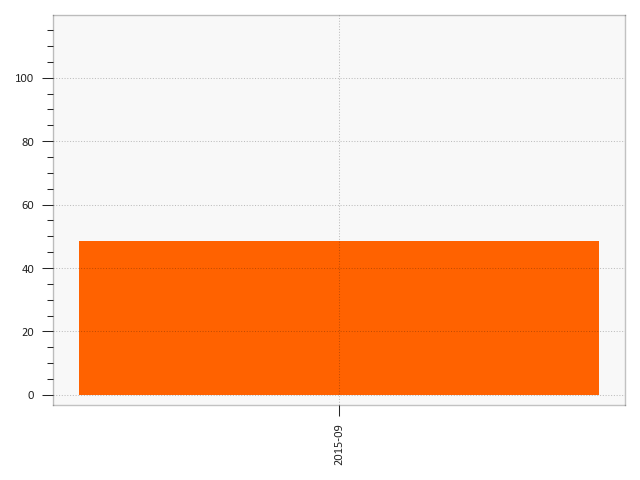
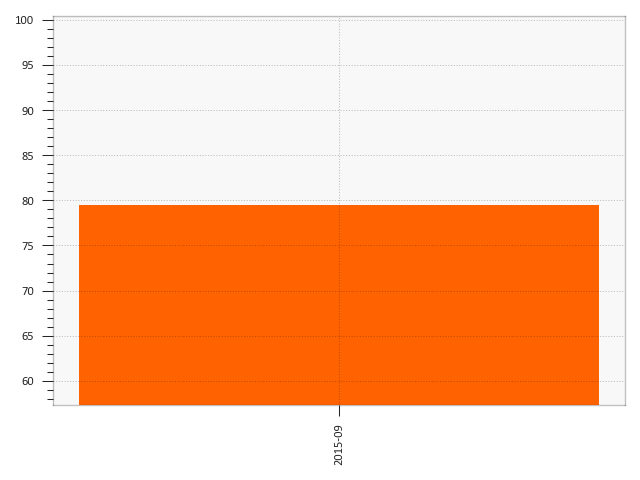
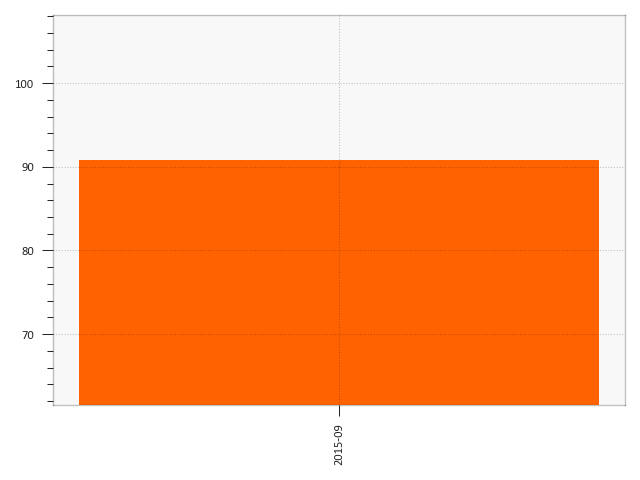
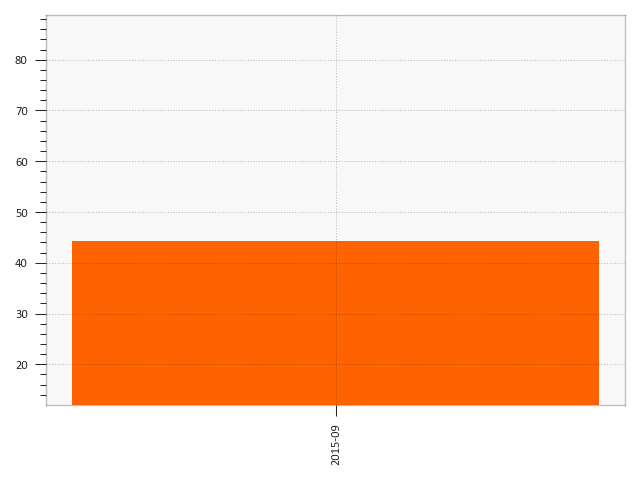
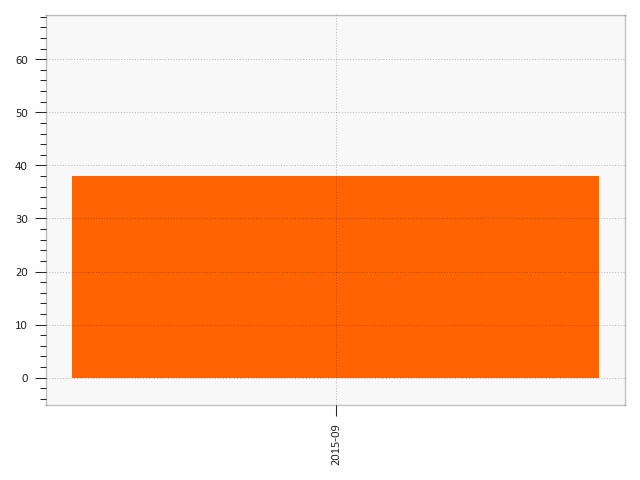
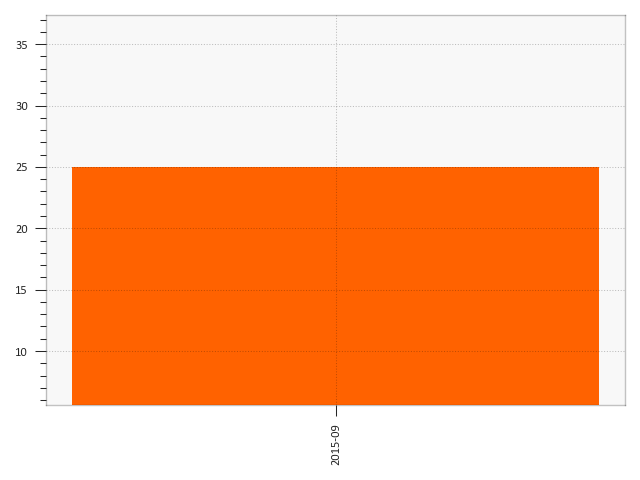
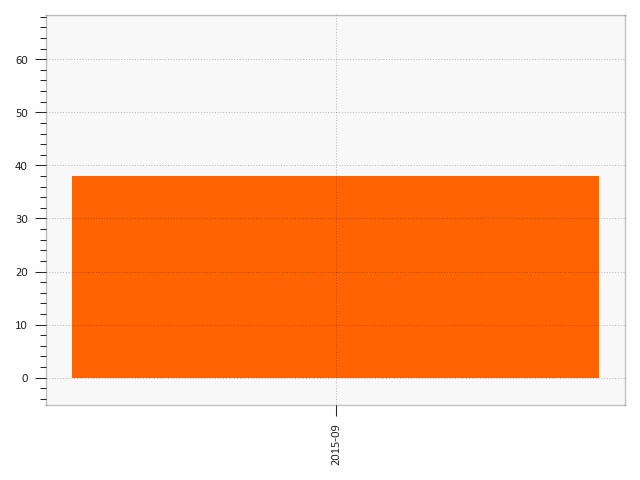
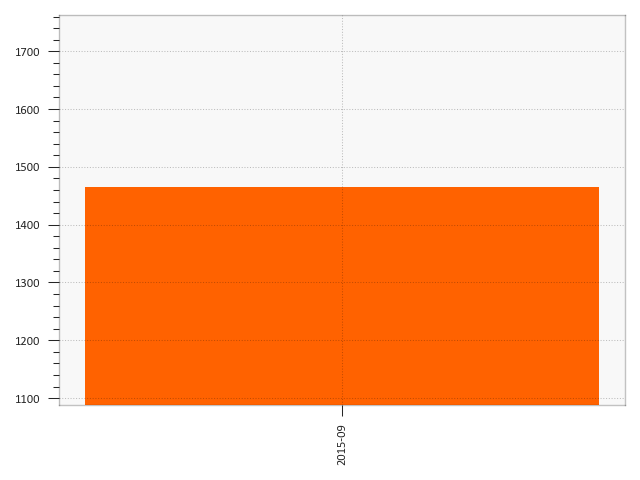
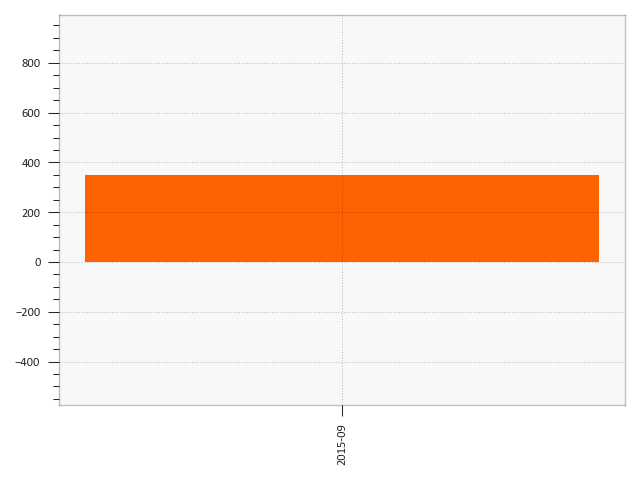
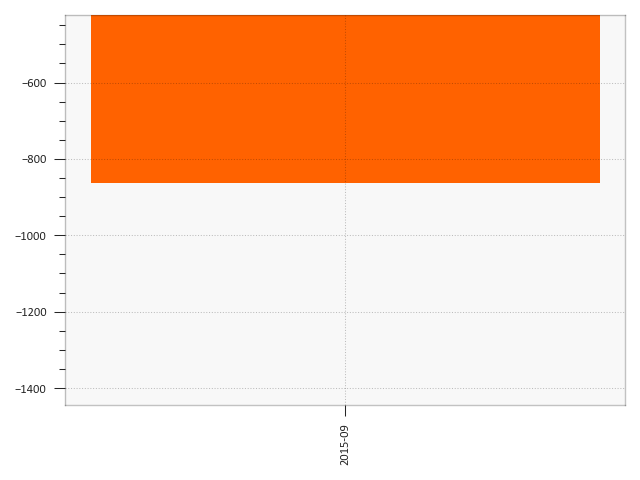
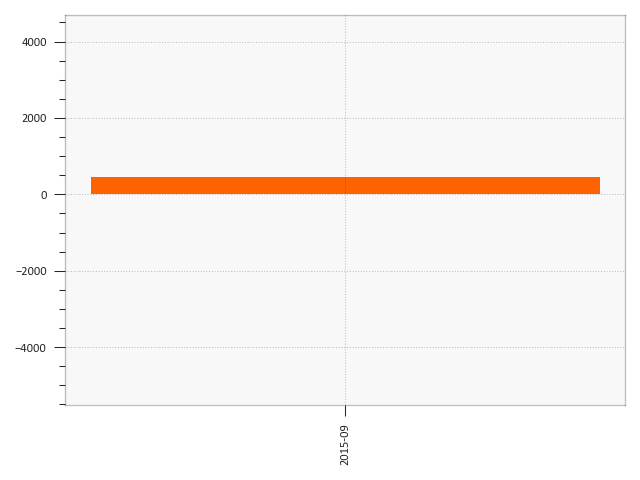
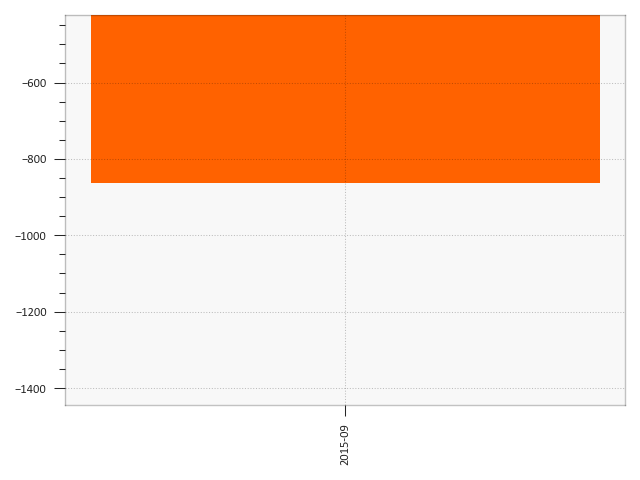
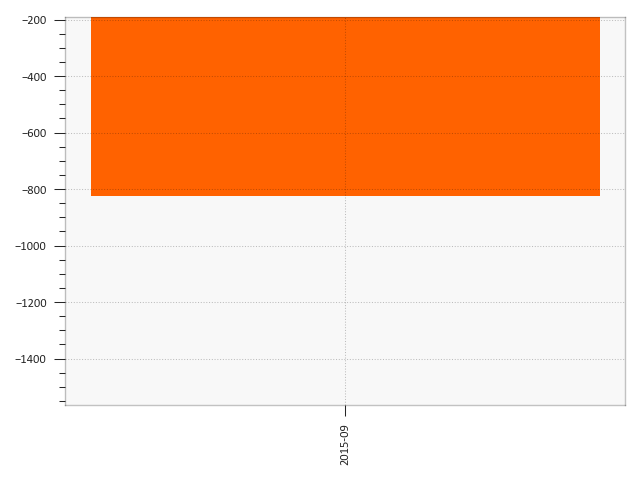
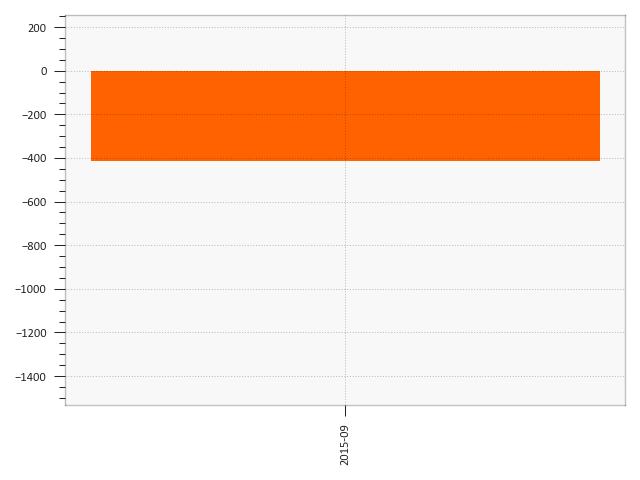
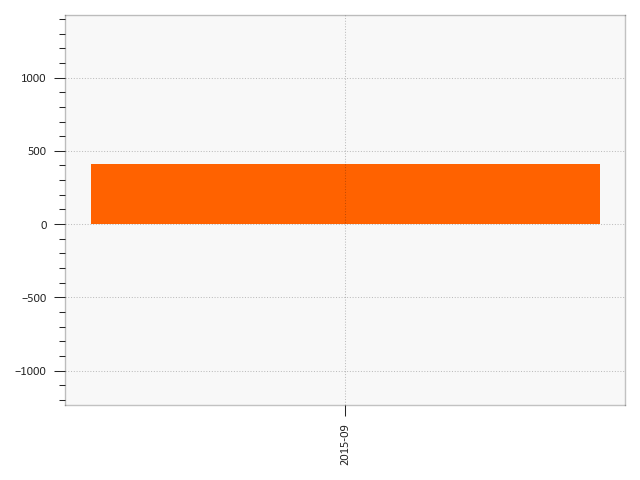
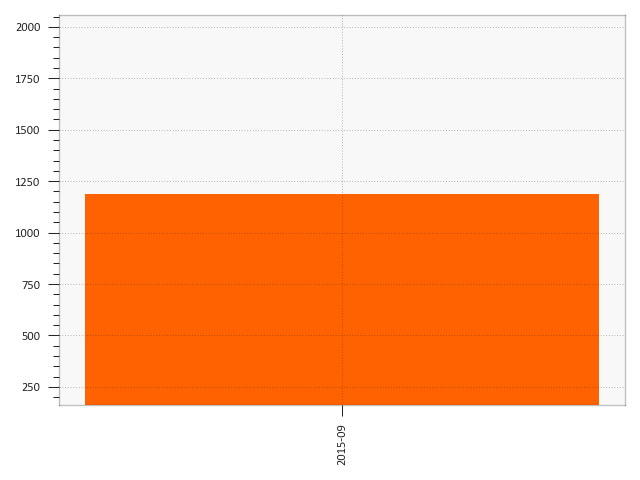
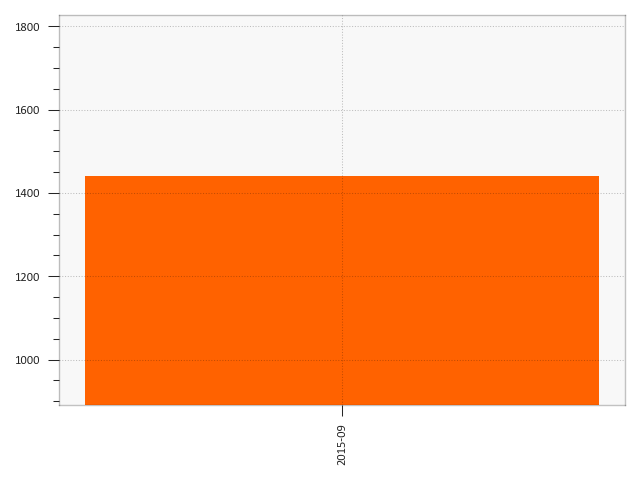
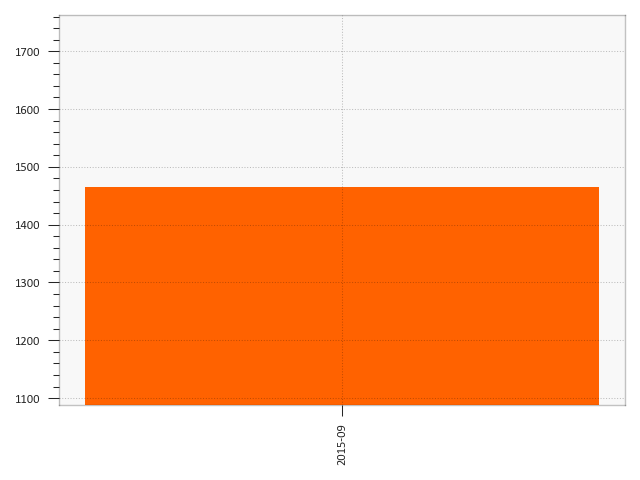
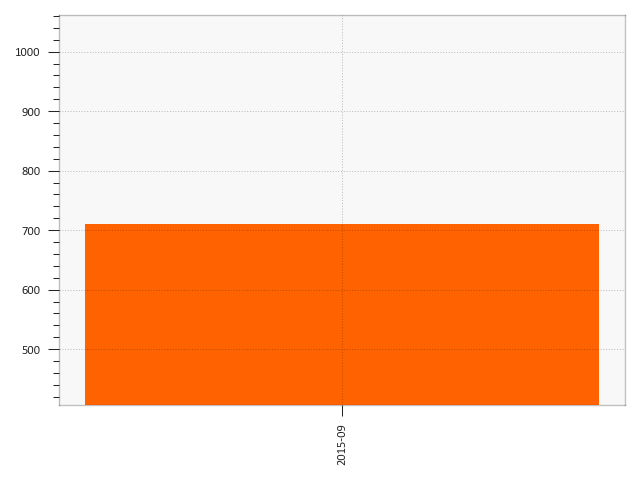

In [20]:
batch_monitoring_report

<h3>Next steps</h3>

We know we've only scratched the surface of all the beautiful and smart things popmon has to offer. But this was just meant to give you a quickstart in using this package. The possible next steps, as we see it, would be:
- finding out which metrics are used and what they do/mean, which we explained <a href="https://www.theanalyticslab.nl/the-statistics-underlying-the-popmon-hood/">here</a>
- finding out if the default settings of these metrics apply to your model

This last step is a very difficult one, in our experience we haven't found a reason yet to deflect from the default values used by popmon. The only reason was to create fixed minimum and maximum values for a feature like age. But we haven't found another reason to adjust the default settings yet. But please let us know if you do and why! 

We hope this article helped you getting started using popmon for the monitoring of model drift. Good luck, and more important, have fun! 